In [ ]:
# Authors:- Tanmay Sawaji(tsawaji) and Ruchik Dama(rdama)

In [2]:
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
import matplotlib.pyplot as plt
import numpy as np
#from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

In [ ]:
train_ds = dsets.MNIST(root='MNIST_data/',train=True,transform=transforms.ToTensor(),download=True)
test = dsets.MNIST(root='MNIST_data/',train=False,transform=transforms.ToTensor(),download=True)
#Creating a validations set which is 10% of the Train Set
indices = np.arange(60000)
validate  = torch.utils.data.Subset(train_ds, indices[:6000])
train=torch.utils.data.Subset(train_ds, indices[6000:])

In [3]:
batch_size = 32

In [4]:
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = True)
validation_loader = torch.utils.data.DataLoader(validate, batch_size=batch_size, shuffle=True)

In [5]:
print('The training dataset:\t',train)
print('\nThe testing dataset:\t',test)
print('\nThe validate dataset:\t',validate)

The training dataset:	 <torch.utils.data.dataset.Subset object at 0x7fe90a457f90>

The testing dataset:	 Dataset MNIST
    Number of datapoints: 10000
    Root location: MNIST_data/
    Split: Test
    StandardTransform
Transform: ToTensor()

The validate dataset:	 <torch.utils.data.dataset.Subset object at 0x7fe96f95b050>


In [6]:
train_loader

In [7]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([32, 1, 28, 28])
torch.Size([32])


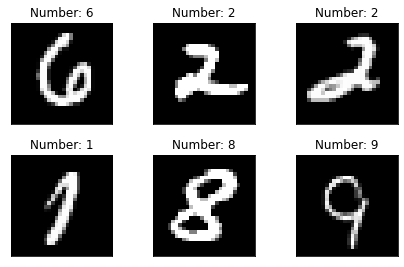

In [8]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(images[i].numpy().squeeze(), cmap='gray', interpolation='none')
  plt.title("Number: {}".format(labels[i]))
  plt.xticks([])
  plt.yticks([])
#fig

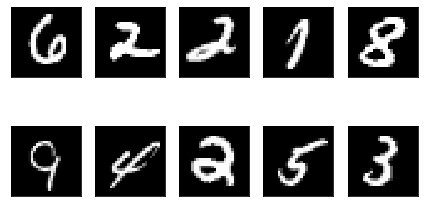

In [9]:
fig,ax=plt.subplots(2,5,True,True)
ax=ax.flatten()
for i in range(10):
  ax[i].imshow(images[i].numpy().squeeze(), cmap='gray', interpolation='none')

    
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [10]:
class CNN(torch.nn.Module):
    def __init__(self):
            super(CNN, self).__init__()

            self.layer=torch.nn.Sequential(
            # outputOfEachConvLayer = [(in_channel + 2*padding - kernel_size) / stride] + 1
            torch.nn.Conv2d(1, 12, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
                
            #In First Layer the output would be (for first layer the we take in-channel as 28 beacause the images is 28x28 pixel)
            # so, [(28 + 2*1 - 3)/1] + 1 = 28.
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            # as kernel_size in maxpool is 2 ,  we have to divide it by 2 28/2=14.
            #Second Layer
            torch.nn.Conv2d(12, 24, kernel_size=3, stride=1, padding=1),
            # After the second convolutional layer the output of this layer is:
            # [(14 + 2*1 - 3)/1] + 1 = 14.
            torch.nn.ReLU(inplace=True),
            #torch.nn.Dropout(p=0.25),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            # Since we applied maxpooling with kernel_size=2 we have to divide by 2, so we get
            # 14 / 2 = 7
            
            )
    
            
            # Linear layer
            self.linear_layers = torch.nn.Sequential(
                    # We have the output_channel=24 of our second conv layer, and 7*7 is derived by the formula 
                    # which is the output of each convolutional layer
                    torch.nn.Linear(in_features=24*7*7, out_features=64),          
                    torch.nn.ReLU(),
                    #torch.nn.Dropout(p=0.25),
                    torch.nn.Linear(64, 10), 
                    #torch.nn.init.xavier_normal_(self.torch.nn.Linear.weight),
                    #torch.nn.init.zeros_(self.torch.nn.Linear.bias),
            )
    
    # Defining forward
    def forward(self, x):
        x = self.layer(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
#Glorot Initialization    
def initialize_weights(m):
      if isinstance(m, torch.nn.Conv2d):
          torch.nn.init.xavier_normal_(m.weight)
          if m.bias is not None:
             torch.nn.init.zeros_(m.bias)
      elif isinstance(m, torch.nn.Linear):
          torch.nn.init.xavier_normal_(m.weight)
          torch.nn.init.zeros_(m.bias)


# instantiate CNN model
model = CNN()
model.apply(initialize_weights)
print(model)

CNN(
  (layer): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=1176, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [11]:
learning_rate = 0.05
criterion = torch.nn.CrossEntropyLoss()    # Softmax is internally computed.
optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate,momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [21]:
for param in model.parameters():
    print(param.size())

torch.Size([12, 1, 3, 3])
torch.Size([12])
torch.Size([24, 12, 3, 3])
torch.Size([24])
torch.Size([64, 1176])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


Training the Deep Learning network ...
total_batch  1687
Size of the testing dataset  torch.Size([10000, 28, 28])
Batch size is :  32
Total number of batches is :  1687
Total number of epochs is : 50
Epoch=  1 , batch =  0 , cost =  2.294276714324951 , accuracy =  0.09375
Epoch=  1 , batch =  625 , cost =  0.133131206035614 , accuracy =  0.9375
Epoch=  1 , batch =  1250 , cost =  0.09459412097930908 , accuracy =  0.9375
Validate Epoch=  1 , batch =  0 , cost =  0.0009992776904255152 , accuracy =  0.9375
Epoch:  1  averaged cost =  0.17927470803260803  train accuracy =  0.9441646919431279


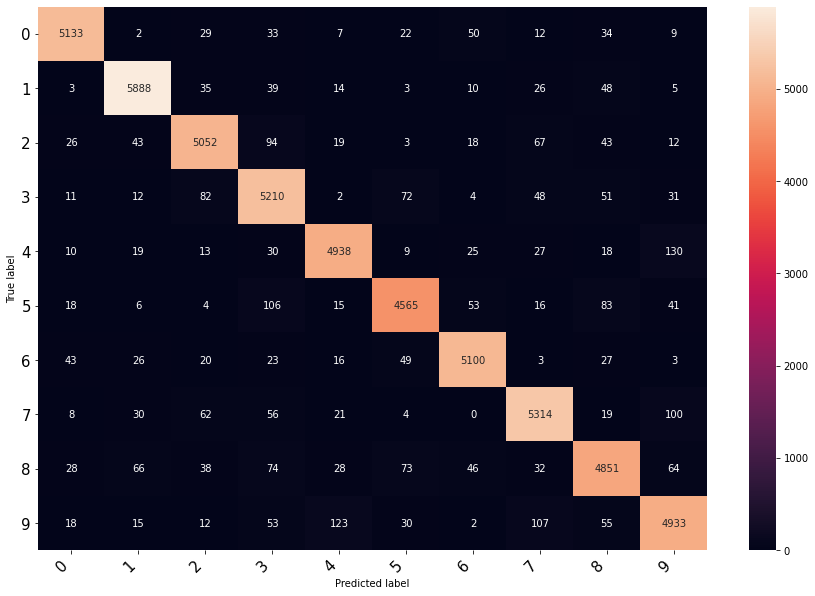

Epoch=  2 , batch =  0 , cost =  0.08112780749797821 , accuracy =  0.96875
Epoch=  2 , batch =  625 , cost =  0.06550566852092743 , accuracy =  1.0
Epoch=  2 , batch =  1250 , cost =  0.017857130616903305 , accuracy =  1.0
Validate Epoch=  2 , batch =  0 , cost =  0.017079129815101624 , accuracy =  1.0
Epoch:  2  averaged cost =  0.07273776829242706  train accuracy =  0.9613447867298578


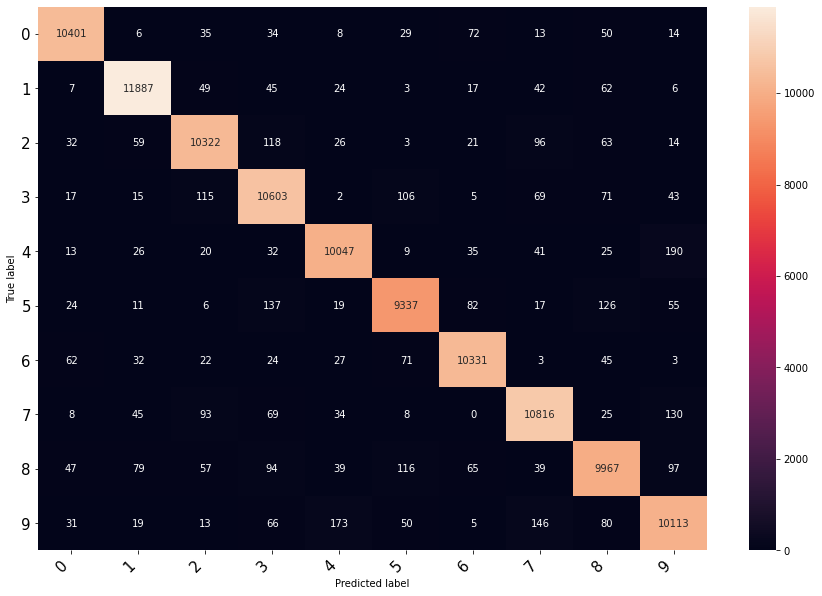

Epoch=  3 , batch =  0 , cost =  0.0038108741864562035 , accuracy =  1.0
Epoch=  3 , batch =  625 , cost =  0.0642833486199379 , accuracy =  0.96875
Epoch=  3 , batch =  1250 , cost =  0.08712682127952576 , accuracy =  0.9375
Validate Epoch=  3 , batch =  0 , cost =  0.0012317525688558817 , accuracy =  1.0
Epoch:  3  averaged cost =  0.0597408302128315  train accuracy =  0.9682810031595577


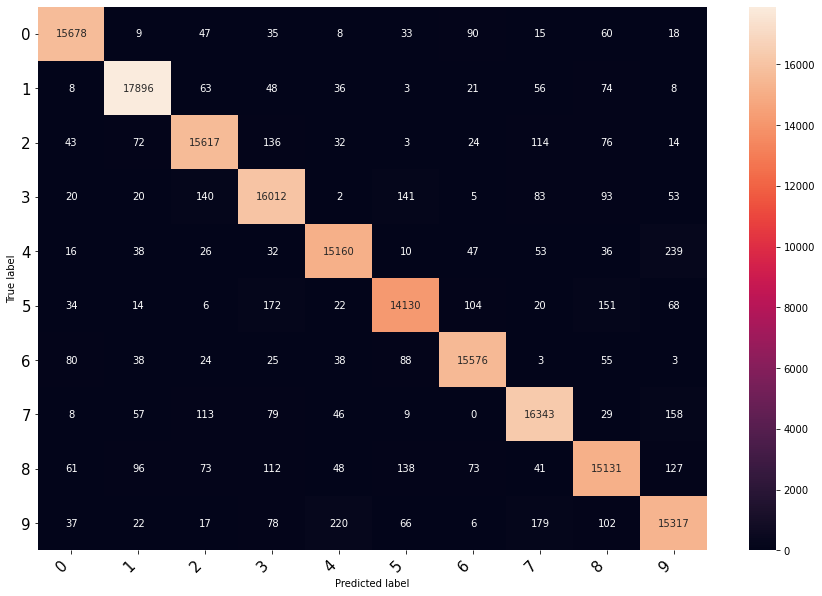

Epoch=  4 , batch =  0 , cost =  0.025140805169939995 , accuracy =  1.0
Epoch=  4 , batch =  625 , cost =  0.0003477784339338541 , accuracy =  1.0
Epoch=  4 , batch =  1250 , cost =  0.0034361069556325674 , accuracy =  1.0
Validate Epoch=  4 , batch =  0 , cost =  0.3068738877773285 , accuracy =  1.0
Epoch:  4  averaged cost =  0.048818353563547134  train accuracy =  0.9724433501184834


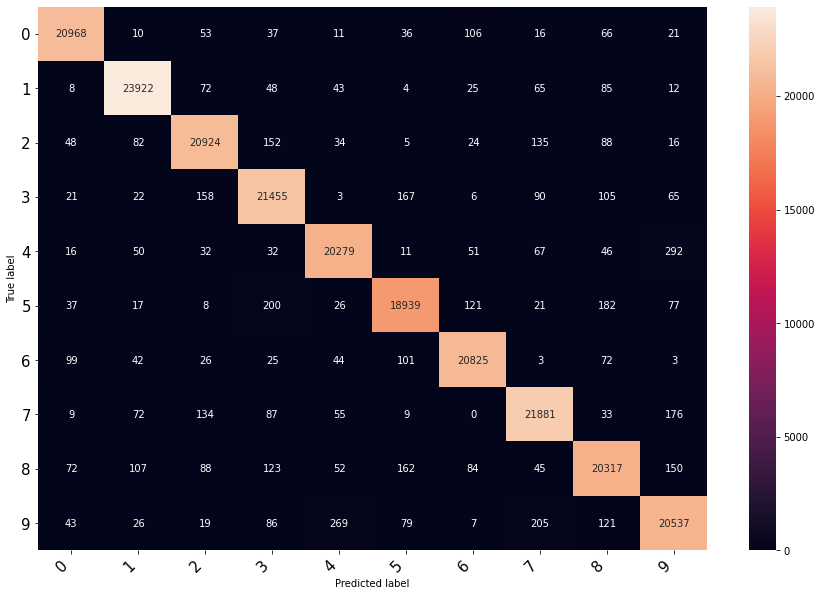

Epoch=  5 , batch =  0 , cost =  0.05777818337082863 , accuracy =  0.96875
Epoch=  5 , batch =  625 , cost =  0.0020734318532049656 , accuracy =  1.0
Epoch=  5 , batch =  1250 , cost =  0.012203052639961243 , accuracy =  1.0
Validate Epoch=  5 , batch =  0 , cost =  0.0018913706298917532 , accuracy =  0.96875
Epoch:  5  averaged cost =  0.04500182718038559  train accuracy =  0.9752702902843602


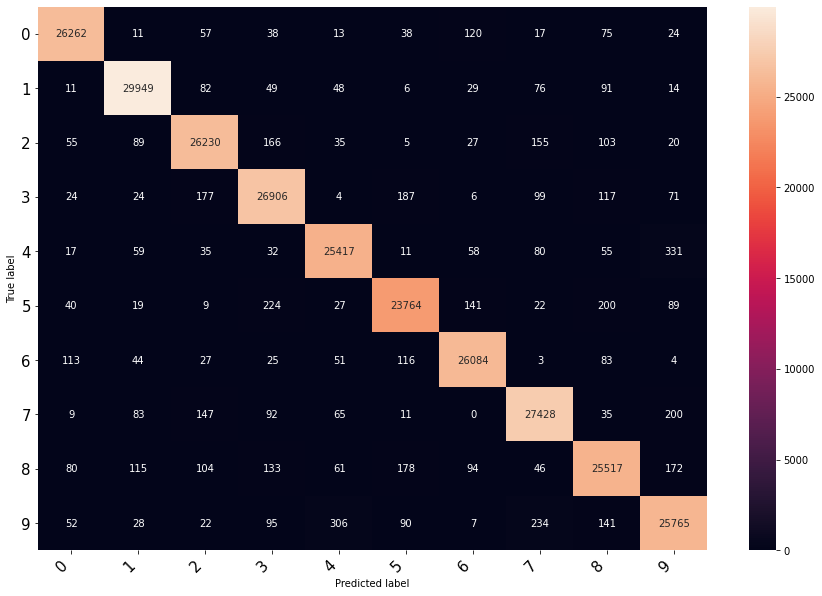

Epoch=  6 , batch =  0 , cost =  0.01323975995182991 , accuracy =  1.0
Epoch=  6 , batch =  625 , cost =  2.165471960324794e-05 , accuracy =  1.0
Epoch=  6 , batch =  1250 , cost =  0.0014842769596725702 , accuracy =  1.0
Validate Epoch=  6 , batch =  0 , cost =  0.3826001286506653 , accuracy =  0.96875
Epoch:  6  averaged cost =  0.04189717769622803  train accuracy =  0.977395586492891


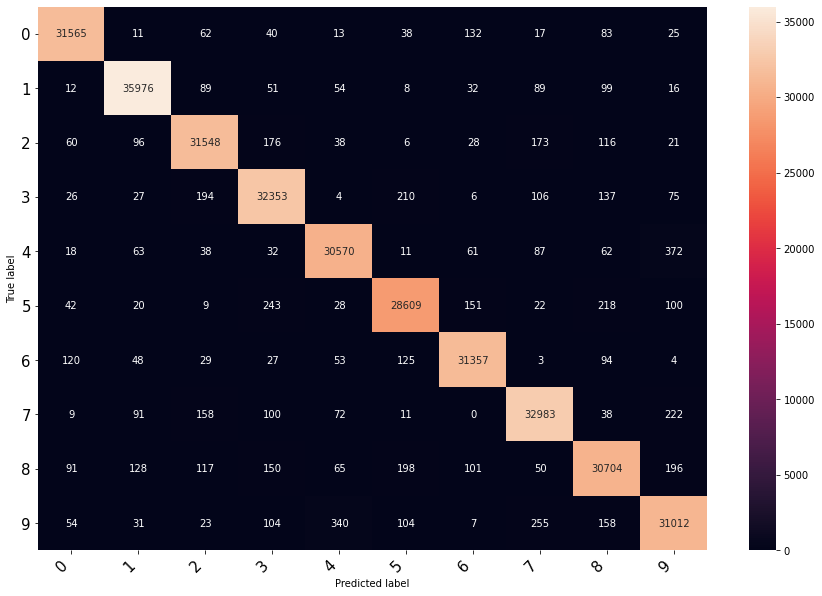

Epoch=  7 , batch =  0 , cost =  0.0032763597555458546 , accuracy =  1.0
Epoch=  7 , batch =  625 , cost =  0.1742524802684784 , accuracy =  0.9375
Epoch=  7 , batch =  1250 , cost =  0.010395976714789867 , accuracy =  1.0
Validate Epoch=  7 , batch =  0 , cost =  7.743231253698468e-05 , accuracy =  0.9375
Epoch:  7  averaged cost =  0.044212762266397476  train accuracy =  0.9787232354434665


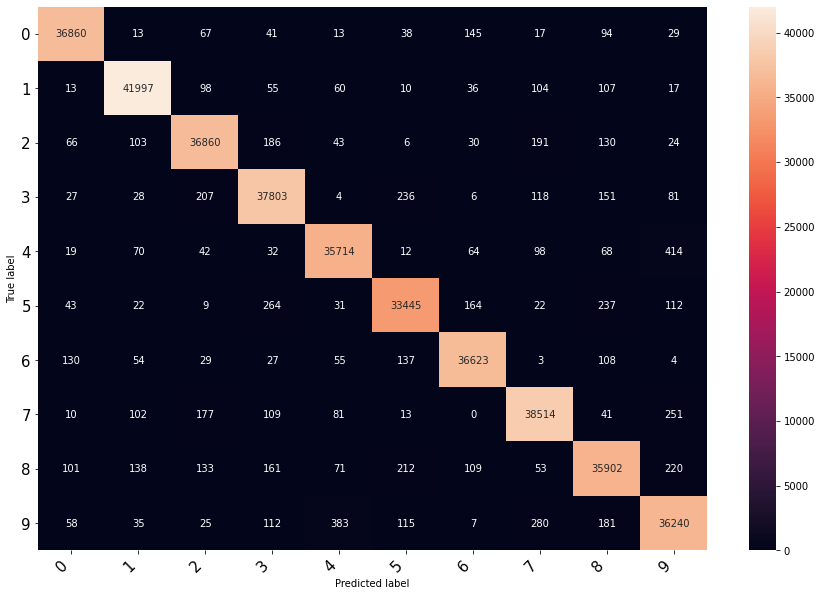

Epoch=  8 , batch =  0 , cost =  0.022588802501559258 , accuracy =  1.0
Epoch=  8 , batch =  625 , cost =  0.1109246090054512 , accuracy =  0.96875
Epoch=  8 , batch =  1250 , cost =  0.0001162620828836225 , accuracy =  1.0
Validate Epoch=  8 , batch =  0 , cost =  0.018169423565268517 , accuracy =  0.96875
Epoch:  8  averaged cost =  0.042966291308403015  train accuracy =  0.9798717046800948


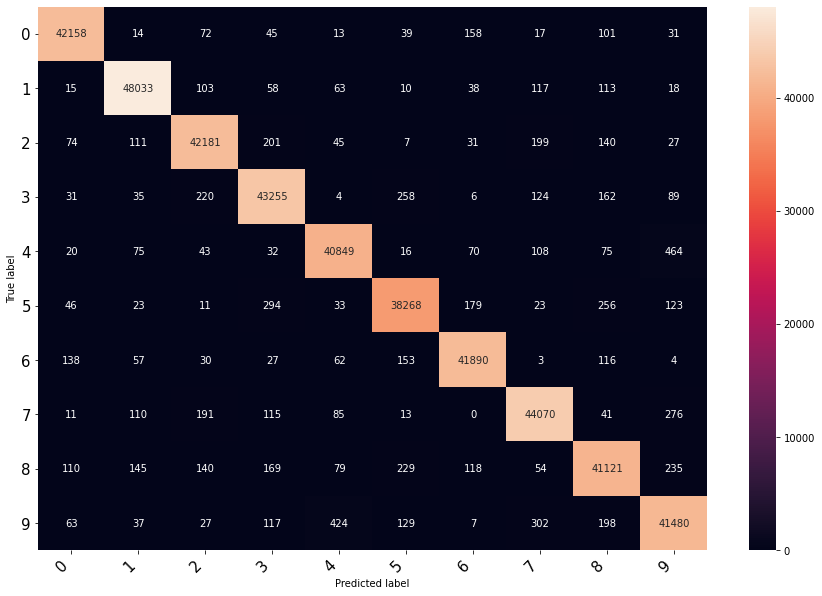

Epoch=  9 , batch =  0 , cost =  6.714133633067831e-05 , accuracy =  1.0
Epoch=  9 , batch =  625 , cost =  0.033682651817798615 , accuracy =  0.96875
Epoch=  9 , batch =  1250 , cost =  0.0029737206641584635 , accuracy =  1.0
Validate Epoch=  9 , batch =  0 , cost =  0.003492204239591956 , accuracy =  0.96875
Epoch:  9  averaged cost =  0.04771249741315842  train accuracy =  0.9806538803317536


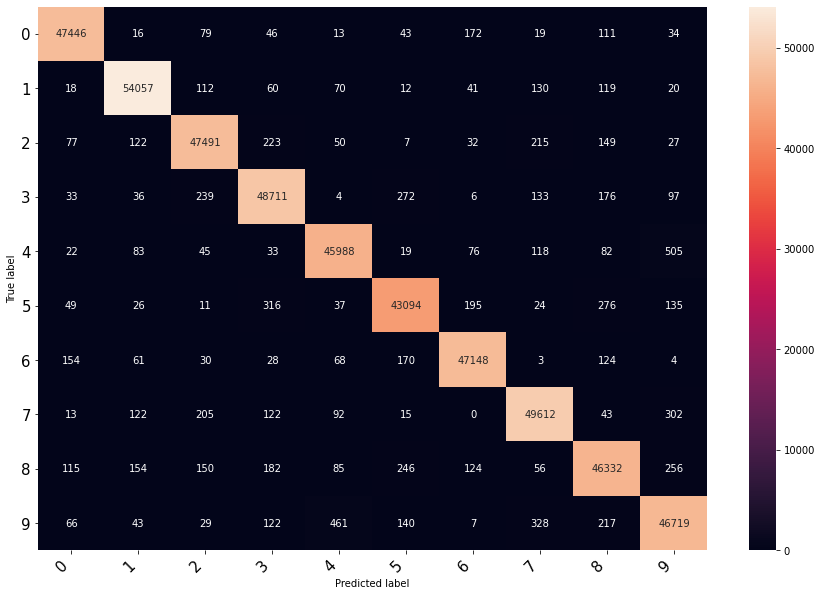

Epoch=  10 , batch =  0 , cost =  1.2568000784085598e-05 , accuracy =  1.0
Epoch=  10 , batch =  625 , cost =  0.11661277711391449 , accuracy =  0.9375
Epoch=  10 , batch =  1250 , cost =  0.001317174406722188 , accuracy =  1.0
Validate Epoch=  10 , batch =  0 , cost =  0.0001556080242153257 , accuracy =  1.0
Epoch:  10  averaged cost =  0.042077962309122086  train accuracy =  0.981461048578199


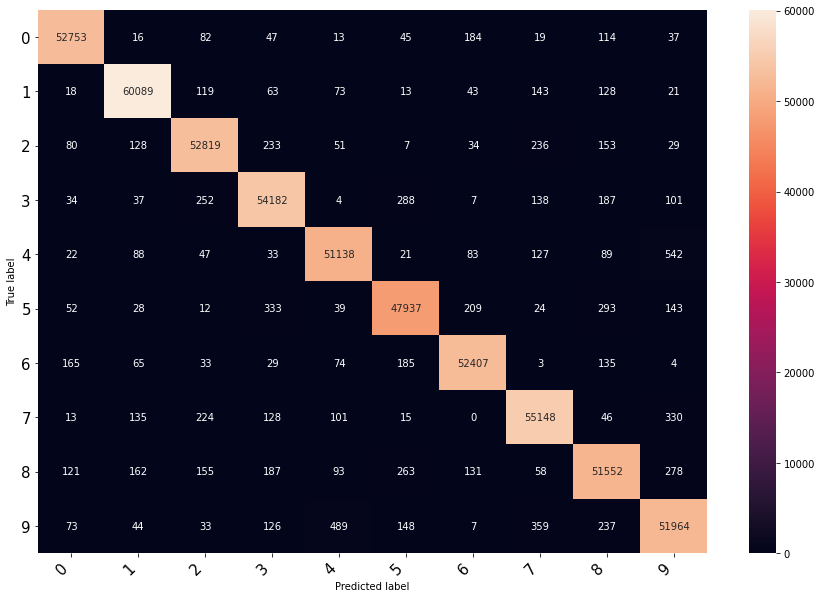

Epoch=  11 , batch =  0 , cost =  0.00012194722512504086 , accuracy =  1.0
Epoch=  11 , batch =  625 , cost =  0.001515858806669712 , accuracy =  1.0
Epoch=  11 , batch =  1250 , cost =  7.214048673631623e-05 , accuracy =  1.0
Validate Epoch=  11 , batch =  0 , cost =  0.0032668623607605696 , accuracy =  0.9375
Epoch:  11  averaged cost =  0.010571751743555069  train accuracy =  0.9828283202283499


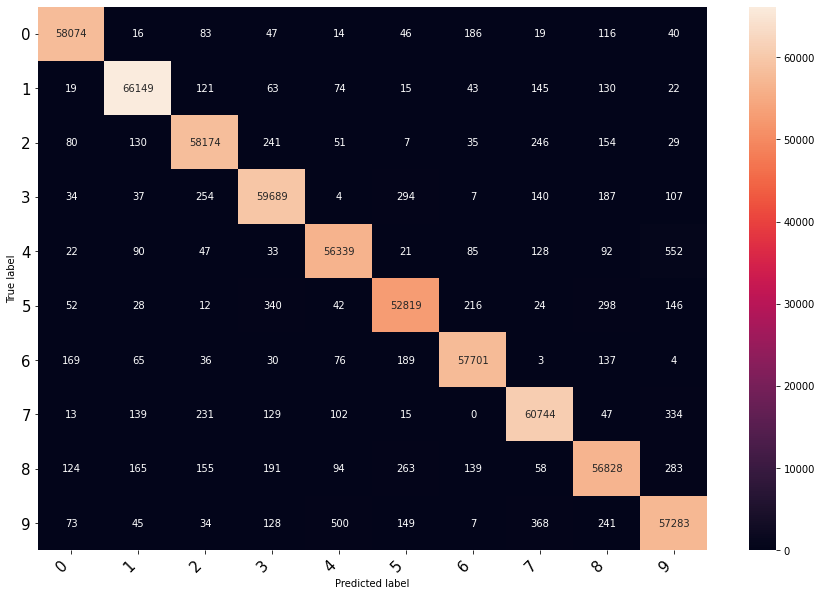

Epoch=  12 , batch =  0 , cost =  0.0002558657433837652 , accuracy =  1.0
Epoch=  12 , batch =  625 , cost =  2.8207672585267574e-05 , accuracy =  1.0
Epoch=  12 , batch =  1250 , cost =  0.06239819526672363 , accuracy =  0.96875
Validate Epoch=  12 , batch =  0 , cost =  4.902396085526561e-06 , accuracy =  1.0
Epoch:  12  averaged cost =  0.005326086655259132  train accuracy =  0.9841343305687204


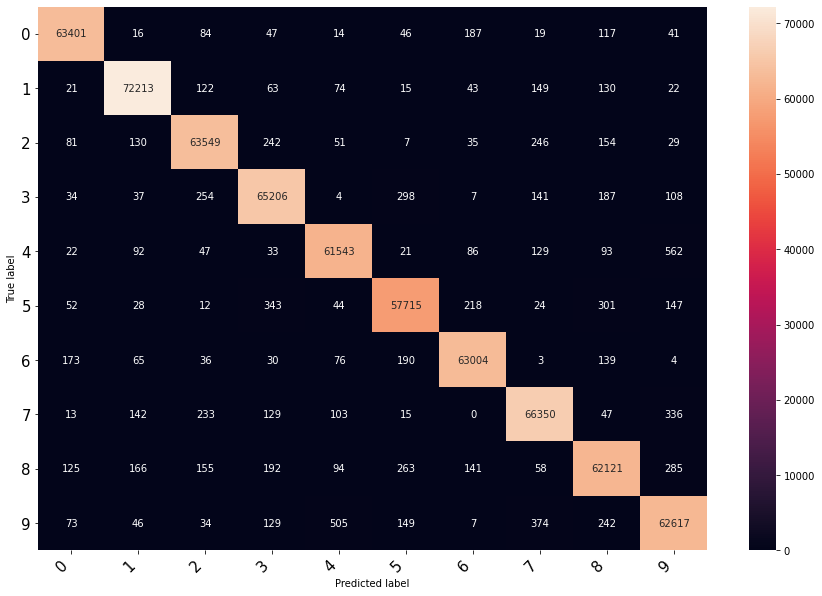

Epoch=  13 , batch =  0 , cost =  0.0006647089030593634 , accuracy =  1.0
Epoch=  13 , batch =  625 , cost =  0.0009460367728024721 , accuracy =  1.0
Epoch=  13 , batch =  1250 , cost =  2.473517815815285e-05 , accuracy =  1.0
Validate Epoch=  13 , batch =  0 , cost =  0.0021225656382739544 , accuracy =  0.9375
Epoch:  13  averaged cost =  0.003880461910739541  train accuracy =  0.9852807145461174


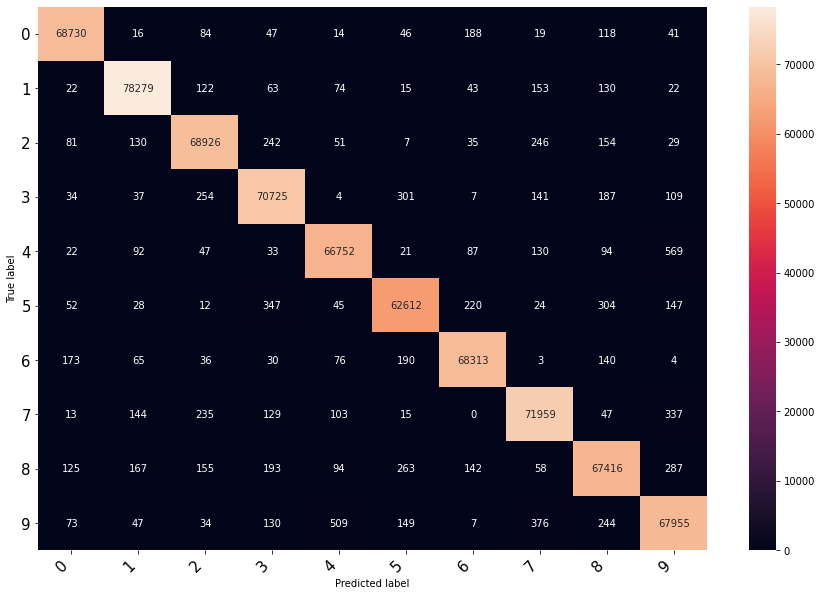

Epoch=  14 , batch =  0 , cost =  1.5440231436514296e-05 , accuracy =  1.0
Epoch=  14 , batch =  625 , cost =  0.0002120115968864411 , accuracy =  1.0
Epoch=  14 , batch =  1250 , cost =  2.5410372472833842e-05 , accuracy =  1.0
Validate Epoch=  14 , batch =  0 , cost =  1.2463897292036563e-05 , accuracy =  0.96875
Epoch:  14  averaged cost =  0.0030734273605048656  train accuracy =  0.9862871318551117


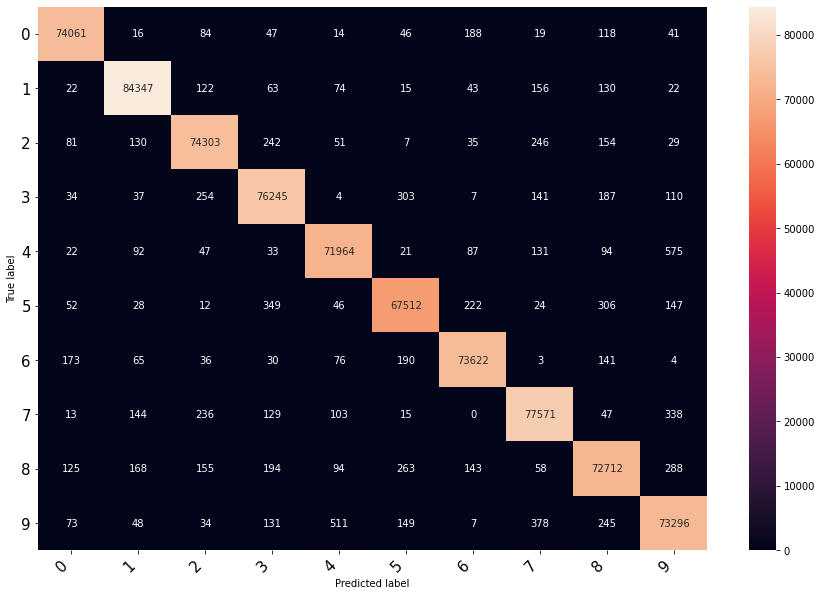

Epoch=  15 , batch =  0 , cost =  0.0012644126545637846 , accuracy =  1.0
Epoch=  15 , batch =  625 , cost =  7.338783802879334e-07 , accuracy =  1.0
Epoch=  15 , batch =  1250 , cost =  2.2201082174433395e-05 , accuracy =  1.0
Validate Epoch=  15 , batch =  0 , cost =  0.023087693378329277 , accuracy =  0.90625
Epoch:  15  averaged cost =  0.0024672914296388626  train accuracy =  0.987169233807267


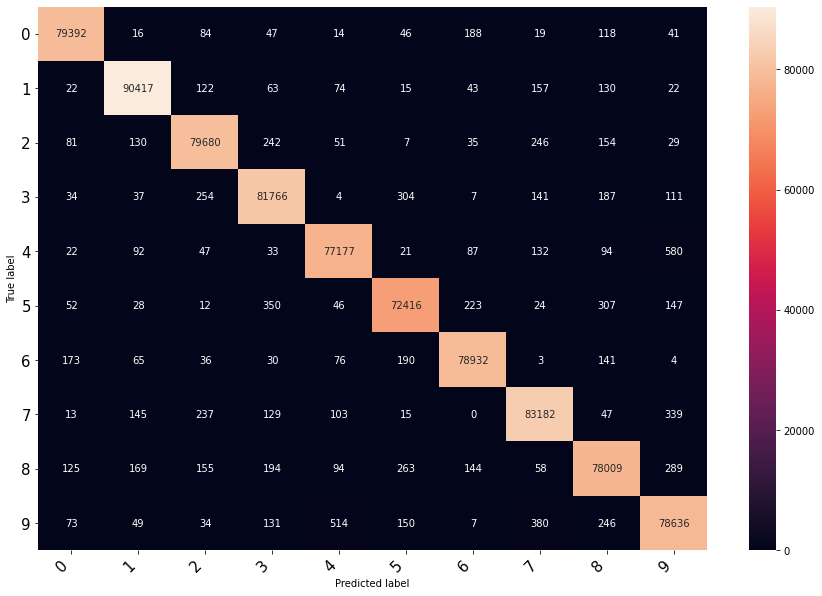

Epoch=  16 , batch =  0 , cost =  1.5002836335042957e-05 , accuracy =  1.0
Epoch=  16 , batch =  625 , cost =  6.109445394031354e-07 , accuracy =  1.0
Epoch=  16 , batch =  1250 , cost =  0.00016340696311090142 , accuracy =  1.0
Validate Epoch=  16 , batch =  0 , cost =  1.4901159417490817e-08 , accuracy =  1.0
Epoch:  16  averaged cost =  0.0020238757133483887  train accuracy =  0.9879422300799763


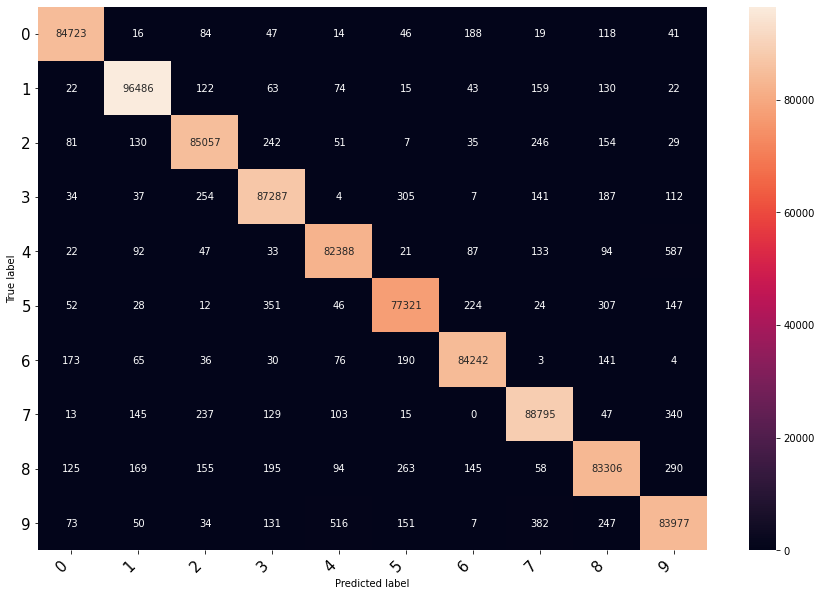

Epoch=  17 , batch =  0 , cost =  0.00935713667422533 , accuracy =  1.0
Epoch=  17 , batch =  625 , cost =  0.0003300649404991418 , accuracy =  1.0
Epoch=  17 , batch =  1250 , cost =  0.0020006708800792694 , accuracy =  1.0
Validate Epoch=  17 , batch =  0 , cost =  1.4901160305669237e-08 , accuracy =  0.96875
Epoch:  17  averaged cost =  0.0016825299244374037  train accuracy =  0.9886308196264287


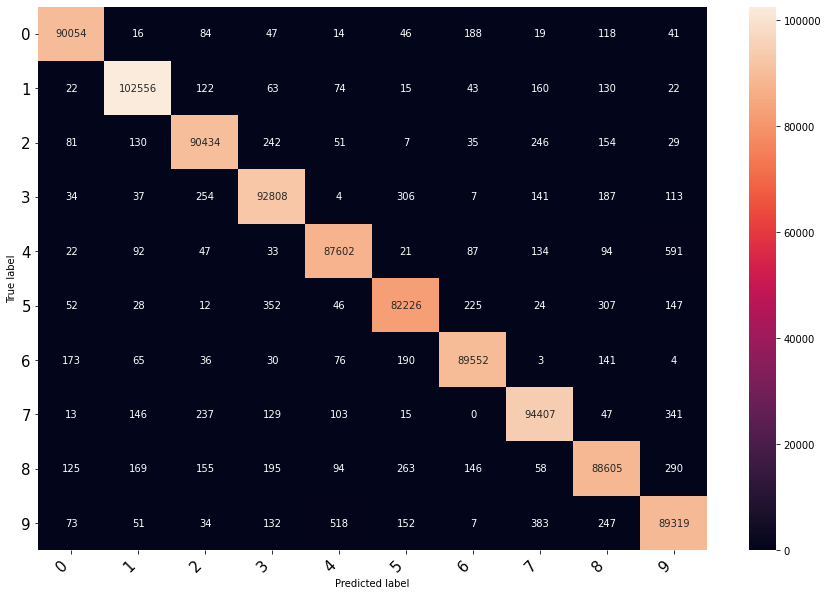

Epoch=  18 , batch =  0 , cost =  0.0023135896772146225 , accuracy =  1.0
Epoch=  18 , batch =  625 , cost =  4.433079823229491e-07 , accuracy =  1.0
Epoch=  18 , batch =  1250 , cost =  0.007476086728274822 , accuracy =  1.0
Validate Epoch=  18 , batch =  0 , cost =  1.2367844419713947e-06 , accuracy =  1.0
Epoch:  18  averaged cost =  0.001435251790098846  train accuracy =  0.9892470132306477


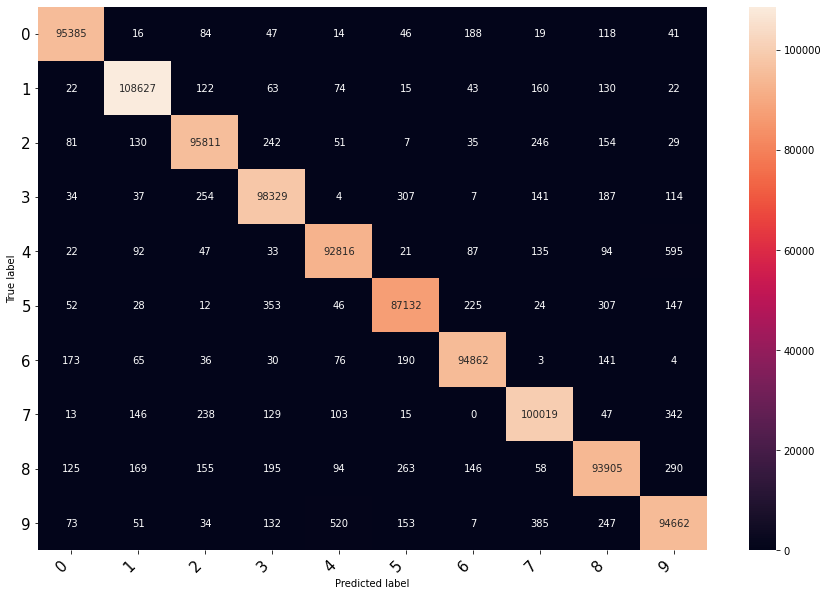

Epoch=  19 , batch =  0 , cost =  0.0003962477494496852 , accuracy =  1.0
Epoch=  19 , batch =  625 , cost =  0.00014635002298746258 , accuracy =  1.0
Epoch=  19 , batch =  1250 , cost =  2.677709017007146e-05 , accuracy =  1.0
Validate Epoch=  19 , batch =  0 , cost =  0.0005294646834954619 , accuracy =  0.96875
Epoch:  19  averaged cost =  0.0012127362424507737  train accuracy =  0.9898012674607134


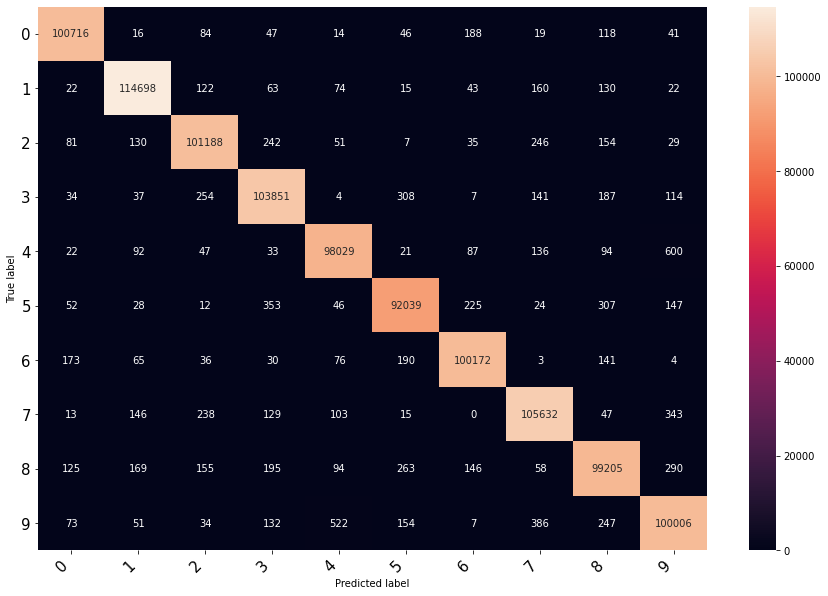

Epoch=  20 , batch =  0 , cost =  1.8626428754942026e-07 , accuracy =  1.0
Epoch=  20 , batch =  625 , cost =  0.002253592247143388 , accuracy =  1.0
Epoch=  20 , batch =  1250 , cost =  4.499958231463097e-05 , accuracy =  1.0
Validate Epoch=  20 , batch =  0 , cost =  3.725289587919178e-08 , accuracy =  1.0
Epoch:  20  averaged cost =  0.0010460906196385622  train accuracy =  0.9903028732227488


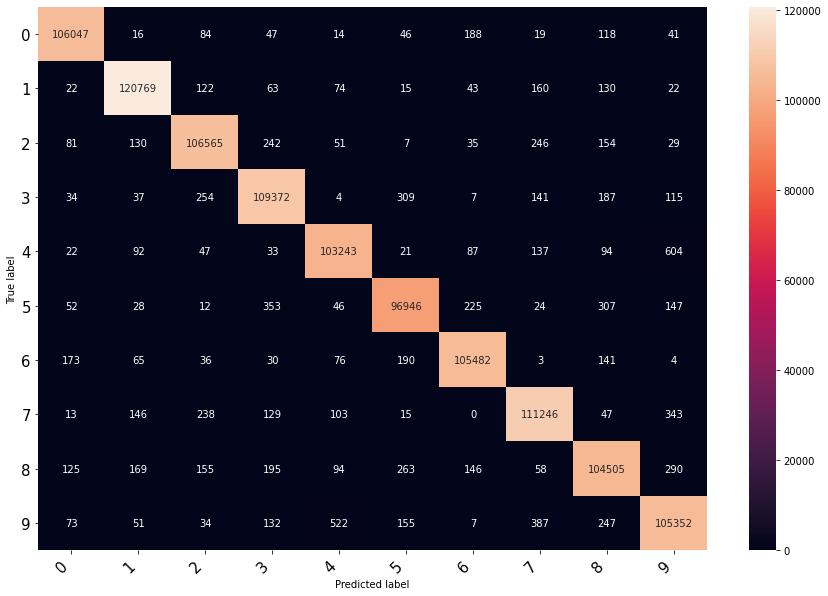

Epoch=  21 , batch =  0 , cost =  1.8163553249905817e-05 , accuracy =  1.0
Epoch=  21 , batch =  625 , cost =  9.692188541521318e-06 , accuracy =  1.0
Epoch=  21 , batch =  1250 , cost =  1.7955412658920977e-06 , accuracy =  1.0
Validate Epoch=  21 , batch =  0 , cost =  4.023300448352529e-07 , accuracy =  1.0
Epoch:  21  averaged cost =  0.0009041674784384668  train accuracy =  0.9907575885804559


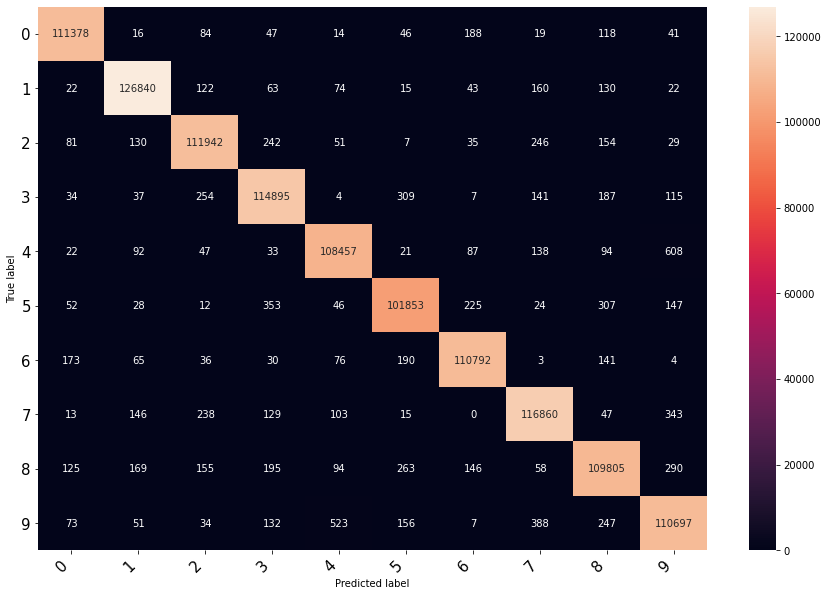

Epoch=  22 , batch =  0 , cost =  8.731136767892167e-05 , accuracy =  1.0
Epoch=  22 , batch =  625 , cost =  0.00011354275920893997 , accuracy =  1.0
Epoch=  22 , batch =  1250 , cost =  2.756710557605402e-07 , accuracy =  1.0
Validate Epoch=  22 , batch =  0 , cost =  1.862642307060014e-07 , accuracy =  1.0
Epoch:  22  averaged cost =  0.0008749121916480362  train accuracy =  0.9911709661783714


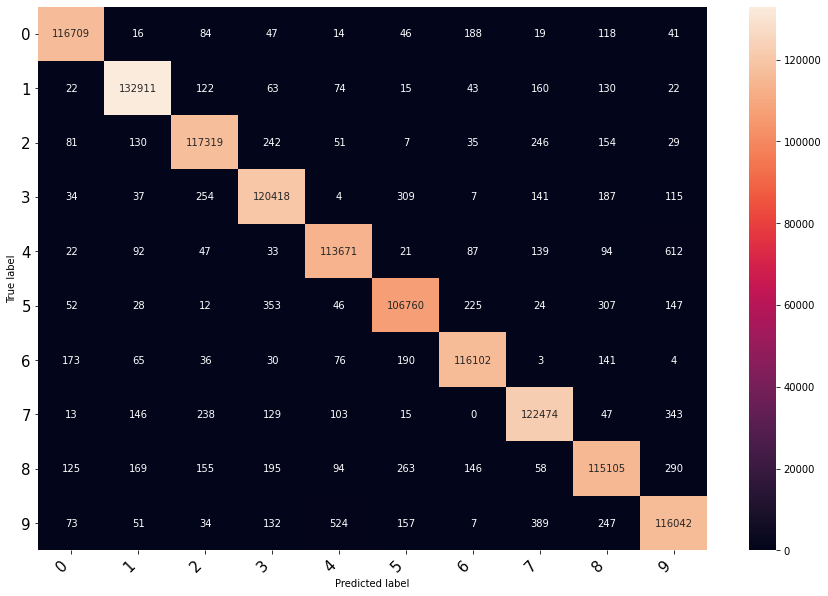

Epoch=  23 , batch =  0 , cost =  2.5405556698387954e-06 , accuracy =  1.0
Epoch=  23 , batch =  625 , cost =  1.2216811228427105e-05 , accuracy =  1.0
Epoch=  23 , batch =  1250 , cost =  0.000493889267090708 , accuracy =  1.0
Validate Epoch=  23 , batch =  0 , cost =  0.00026804953813552856 , accuracy =  0.96875
Epoch:  23  averaged cost =  0.0008569372002966702  train accuracy =  0.9915492028126932


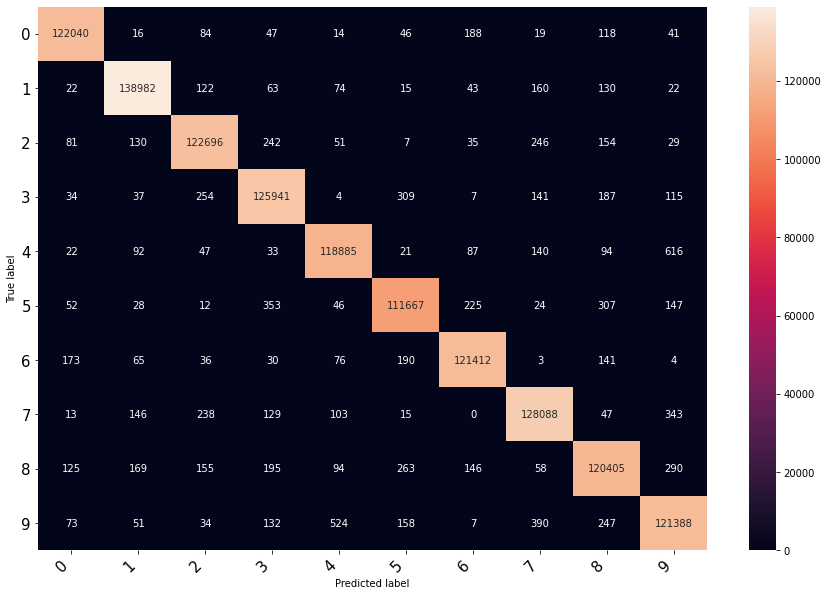

Epoch=  24 , batch =  0 , cost =  3.1196686904877424e-05 , accuracy =  1.0
Epoch=  24 , batch =  625 , cost =  1.3118203241901938e-05 , accuracy =  1.0
Epoch=  24 , batch =  1250 , cost =  2.3874503312981687e-05 , accuracy =  1.0
Validate Epoch=  24 , batch =  0 , cost =  2.8312166477917344e-07 , accuracy =  0.9375
Epoch:  24  averaged cost =  0.0008440265664830804  train accuracy =  0.9918959197274881


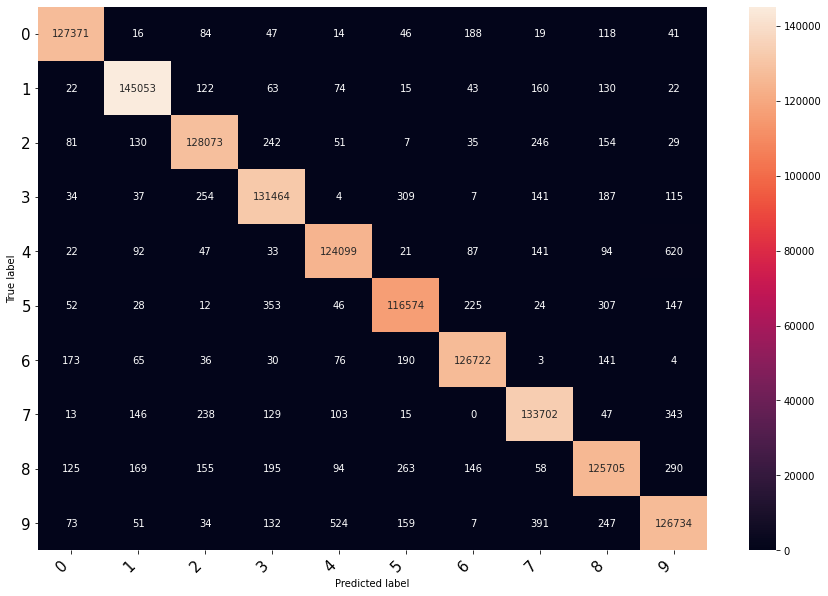

Epoch=  25 , batch =  0 , cost =  0.0008144329767674208 , accuracy =  1.0
Epoch=  25 , batch =  625 , cost =  0.0005175193655304611 , accuracy =  1.0
Epoch=  25 , batch =  1250 , cost =  2.022767830567318e-06 , accuracy =  1.0
Validate Epoch=  25 , batch =  0 , cost =  0.010991649702191353 , accuracy =  1.0
Epoch:  25  averaged cost =  0.0008361721993423998  train accuracy =  0.9922148992890996


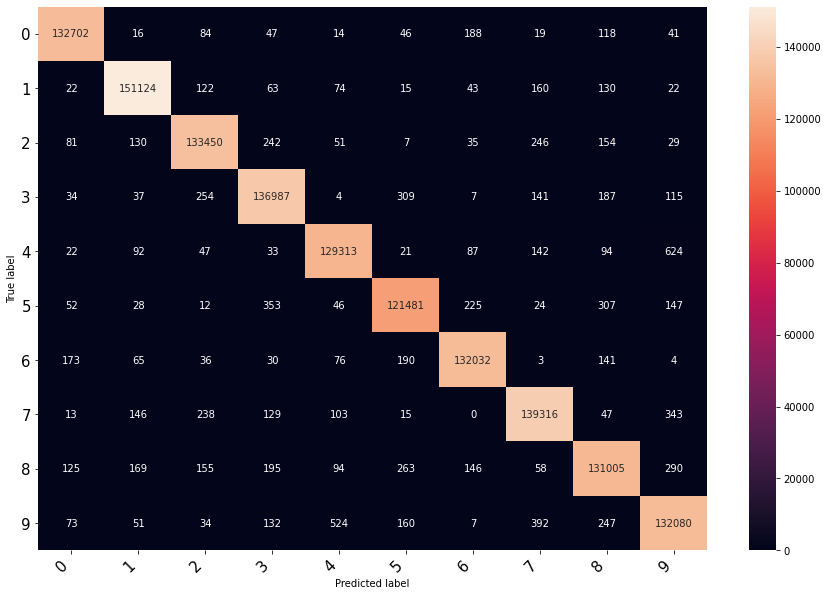

Epoch=  26 , batch =  0 , cost =  2.1523637769860215e-05 , accuracy =  1.0
Epoch=  26 , batch =  625 , cost =  0.0035570384934544563 , accuracy =  1.0
Epoch=  26 , batch =  1250 , cost =  6.63094624542282e-07 , accuracy =  1.0
Validate Epoch=  26 , batch =  0 , cost =  1.937120941875037e-06 , accuracy =  1.0
Epoch:  26  averaged cost =  0.0008231244282796979  train accuracy =  0.9925093419613562


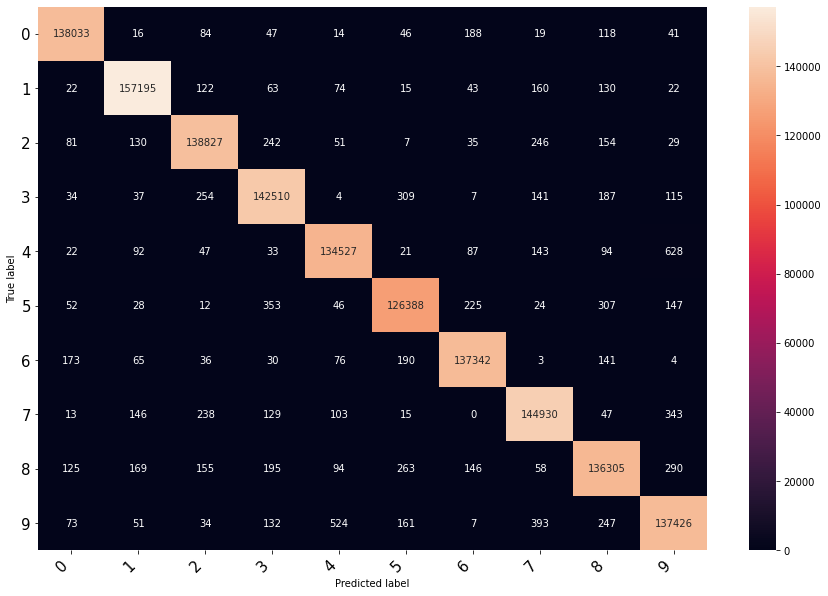

Epoch=  27 , batch =  0 , cost =  1.994770354940556e-05 , accuracy =  1.0
Epoch=  27 , batch =  625 , cost =  1.8092483514919877e-05 , accuracy =  1.0
Epoch=  27 , batch =  1250 , cost =  0.0022037511225789785 , accuracy =  1.0
Validate Epoch=  27 , batch =  0 , cost =  0.00010377278522355482 , accuracy =  0.96875
Epoch:  27  averaged cost =  0.0008140479912981391  train accuracy =  0.9927819740652976


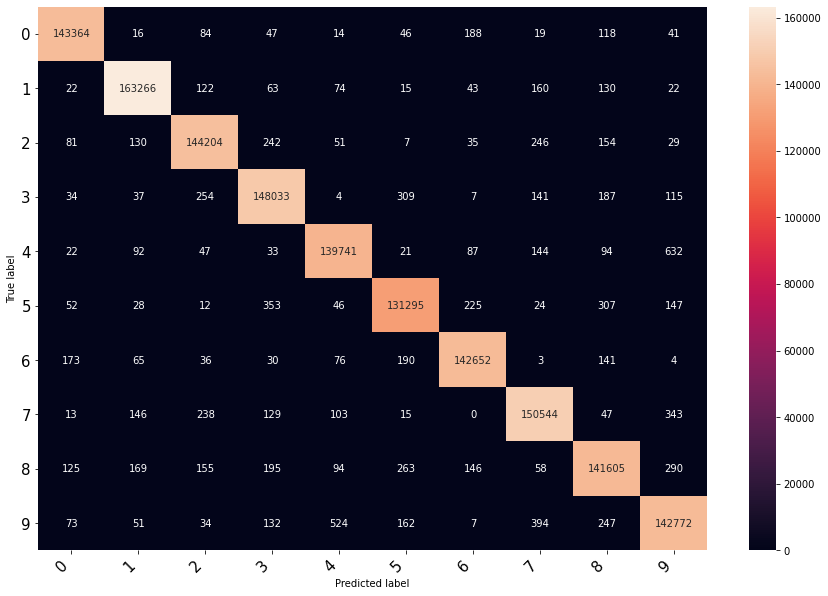

Epoch=  28 , batch =  0 , cost =  0.010616324841976166 , accuracy =  1.0
Epoch=  28 , batch =  625 , cost =  5.736902153330448e-07 , accuracy =  1.0
Epoch=  28 , batch =  1250 , cost =  0.00569418678060174 , accuracy =  1.0
Validate Epoch=  28 , batch =  0 , cost =  0.0 , accuracy =  1.0
Epoch:  28  averaged cost =  0.0008052917546592653  train accuracy =  0.993035793627285


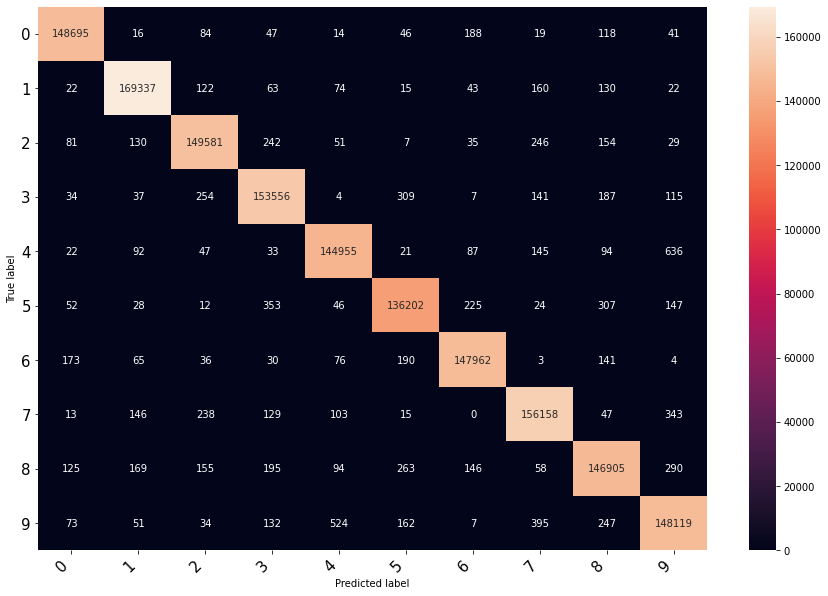

Epoch=  29 , batch =  0 , cost =  0.0006006633630022407 , accuracy =  1.0
Epoch=  29 , batch =  625 , cost =  0.0 , accuracy =  1.0
Epoch=  29 , batch =  1250 , cost =  5.913622953812592e-05 , accuracy =  1.0
Validate Epoch=  29 , batch =  0 , cost =  1.0430807861894209e-07 , accuracy =  0.9375
Epoch:  29  averaged cost =  0.0007974435575306416  train accuracy =  0.9932721083918941


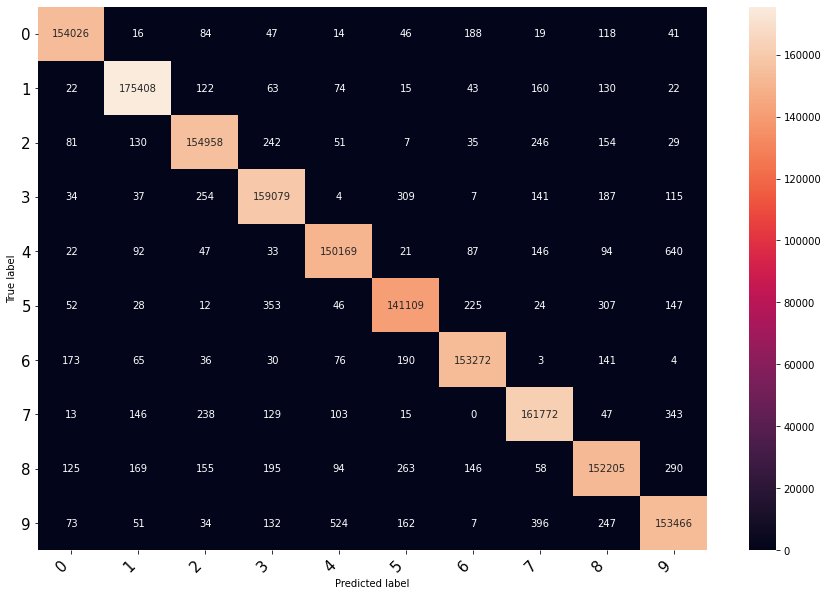

Epoch=  30 , batch =  0 , cost =  6.109836249379441e-05 , accuracy =  1.0
Epoch=  30 , batch =  625 , cost =  1.2628481727006147e-06 , accuracy =  1.0
Epoch=  30 , batch =  1250 , cost =  0.0008854109328240156 , accuracy =  1.0
Validate Epoch=  30 , batch =  0 , cost =  2.2351738238057806e-08 , accuracy =  1.0
Epoch:  30  averaged cost =  0.0007890705019235611  train accuracy =  0.9934926688388626


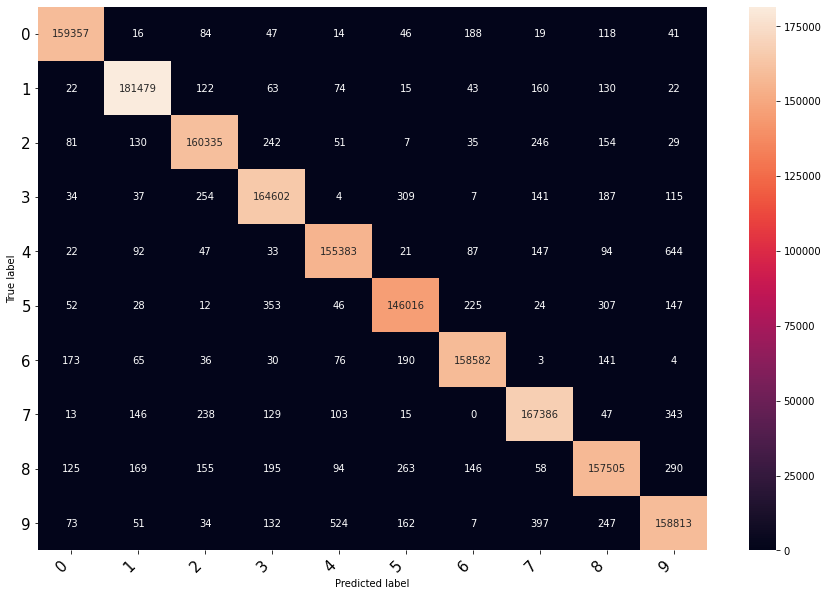

Epoch=  31 , batch =  0 , cost =  8.697818884684239e-06 , accuracy =  1.0
Epoch=  31 , batch =  625 , cost =  2.335710860279505e-06 , accuracy =  1.0
Epoch=  31 , batch =  1250 , cost =  2.0356092136353254e-05 , accuracy =  1.0
Validate Epoch=  31 , batch =  0 , cost =  8.642613806841837e-07 , accuracy =  1.0
Epoch:  31  averaged cost =  0.0007760585285723209  train accuracy =  0.993698999579575


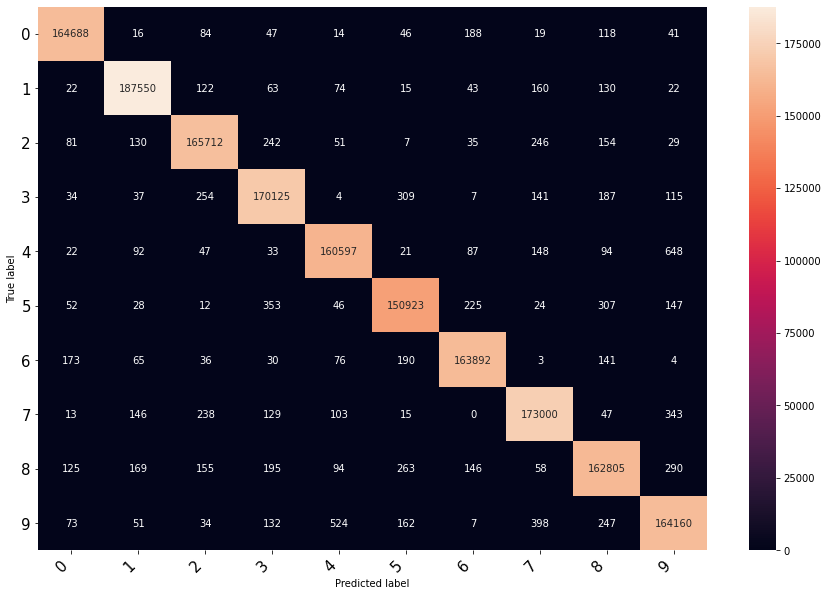

Epoch=  32 , batch =  0 , cost =  0.0001817062875488773 , accuracy =  1.0
Epoch=  32 , batch =  625 , cost =  0.0001596380170667544 , accuracy =  1.0
Epoch=  32 , batch =  1250 , cost =  5.693111597793177e-05 , accuracy =  1.0
Validate Epoch=  32 , batch =  0 , cost =  0.0 , accuracy =  1.0
Epoch:  32  averaged cost =  0.0007752702222205698  train accuracy =  0.9938924346489929


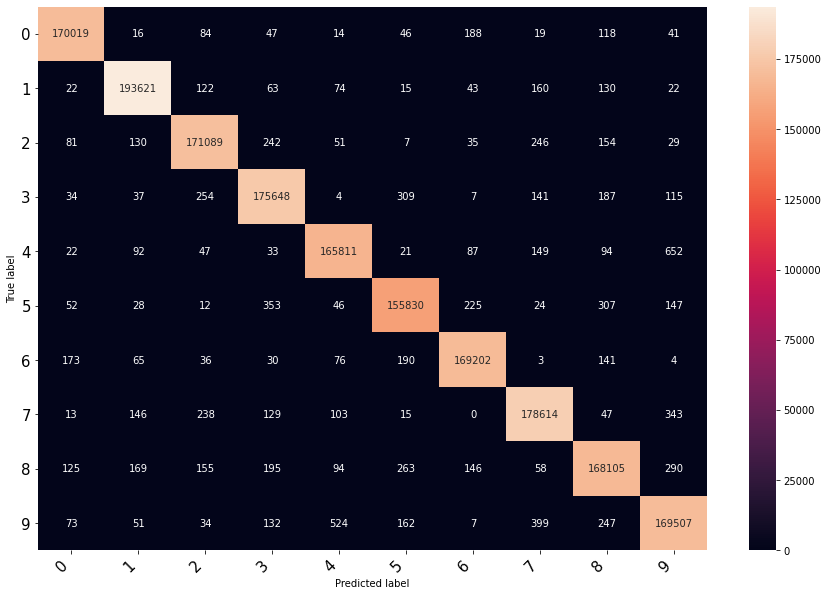

Epoch=  33 , batch =  0 , cost =  5.178128503757762e-07 , accuracy =  1.0
Epoch=  33 , batch =  625 , cost =  8.015936145966407e-06 , accuracy =  1.0
Epoch=  33 , batch =  1250 , cost =  0.00017850127187557518 , accuracy =  1.0
Validate Epoch=  33 , batch =  0 , cost =  1.4901144140821998e-07 , accuracy =  1.0
Epoch:  33  averaged cost =  0.0007744923932477832  train accuracy =  0.9940741463808703


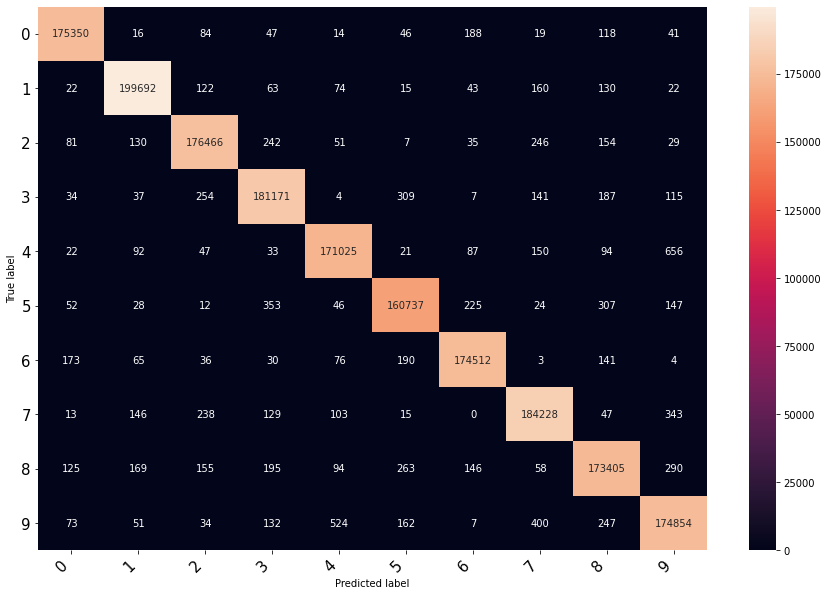

Epoch=  34 , batch =  0 , cost =  0.0005755759193561971 , accuracy =  1.0
Epoch=  34 , batch =  625 , cost =  6.177954492159188e-05 , accuracy =  1.0
Epoch=  34 , batch =  1250 , cost =  1.5050034107844112e-06 , accuracy =  1.0
Validate Epoch=  34 , batch =  0 , cost =  3.725289587919178e-08 , accuracy =  1.0
Epoch:  34  averaged cost =  0.0007736889529041946  train accuracy =  0.9942451691873432


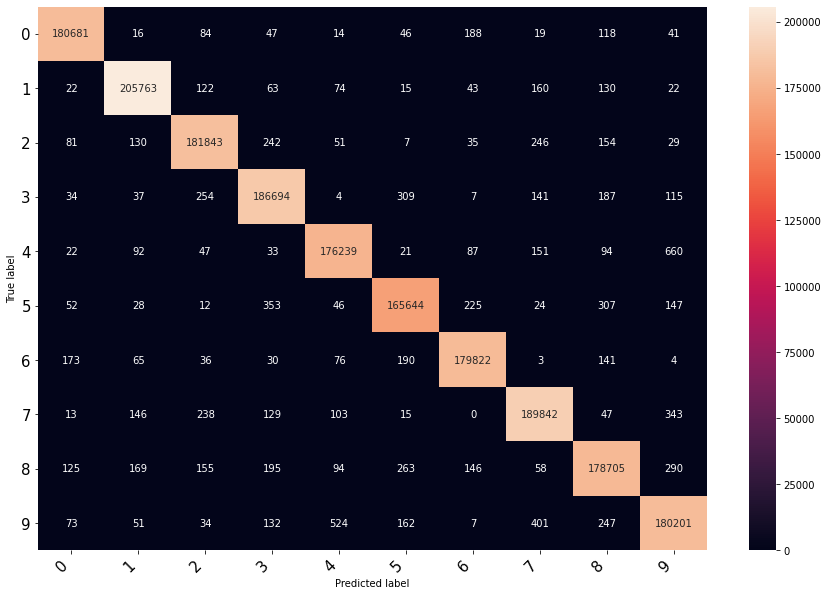

Epoch=  35 , batch =  0 , cost =  6.779985710636538e-07 , accuracy =  1.0
Epoch=  35 , batch =  625 , cost =  0.00011413915490265936 , accuracy =  1.0
Epoch=  35 , batch =  1250 , cost =  8.966524910647422e-05 , accuracy =  1.0
Validate Epoch=  35 , batch =  0 , cost =  0.0015426567988470197 , accuracy =  1.0
Epoch:  35  averaged cost =  0.0007734374958090484  train accuracy =  0.9944064192620176


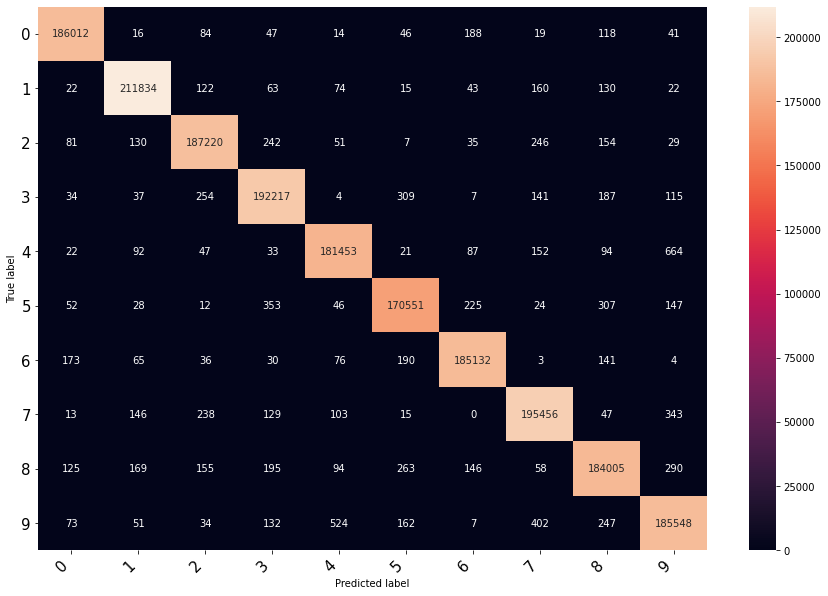

Epoch=  36 , batch =  0 , cost =  0.0007653555367141962 , accuracy =  1.0
Epoch=  36 , batch =  625 , cost =  9.078028597286902e-06 , accuracy =  1.0
Epoch=  36 , batch =  1250 , cost =  0.00015030676149763167 , accuracy =  1.0
Validate Epoch=  36 , batch =  0 , cost =  9.982980373024475e-06 , accuracy =  1.0
Epoch:  36  averaged cost =  0.0007721642032265663  train accuracy =  0.9945587109992101


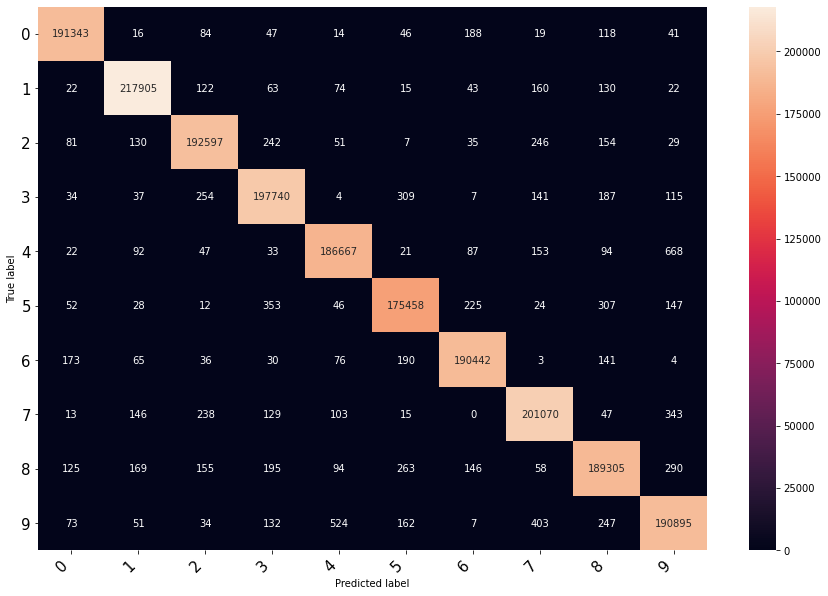

Epoch=  37 , batch =  0 , cost =  2.0861595828591817e-07 , accuracy =  1.0
Epoch=  37 , batch =  625 , cost =  0.0004966785782016814 , accuracy =  1.0
Epoch=  37 , batch =  1250 , cost =  1.4901159417490817e-08 , accuracy =  1.0
Validate Epoch=  37 , batch =  0 , cost =  0.002089935587719083 , accuracy =  0.96875
Epoch:  37  averaged cost =  0.0007721089059486985  train accuracy =  0.9947027707506084


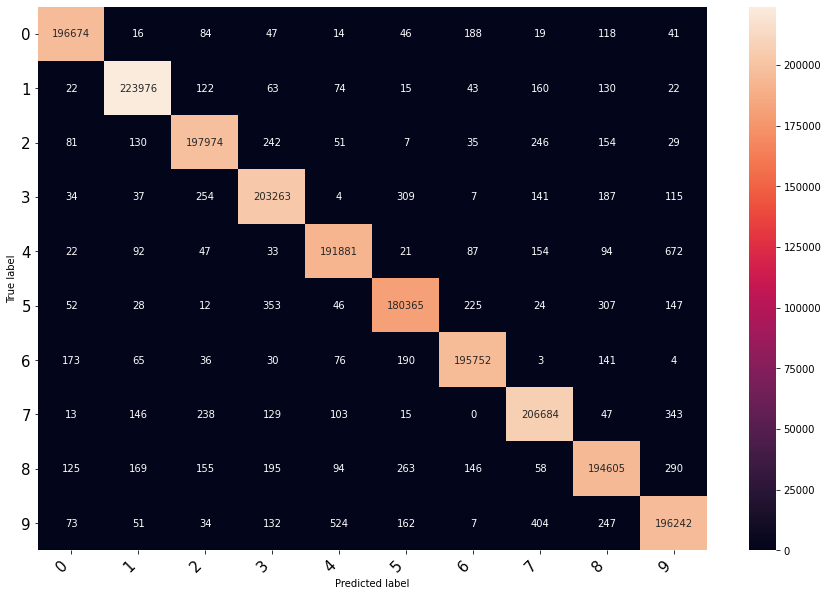

Epoch=  38 , batch =  0 , cost =  6.999452307354659e-05 , accuracy =  1.0
Epoch=  38 , batch =  625 , cost =  0.0006281815585680306 , accuracy =  1.0
Epoch=  38 , batch =  1250 , cost =  6.407445880540763e-07 , accuracy =  1.0
Validate Epoch=  38 , batch =  0 , cost =  4.771770181832835e-05 , accuracy =  1.0
Epoch:  38  averaged cost =  0.0007707161130383611  train accuracy =  0.9948392484098278


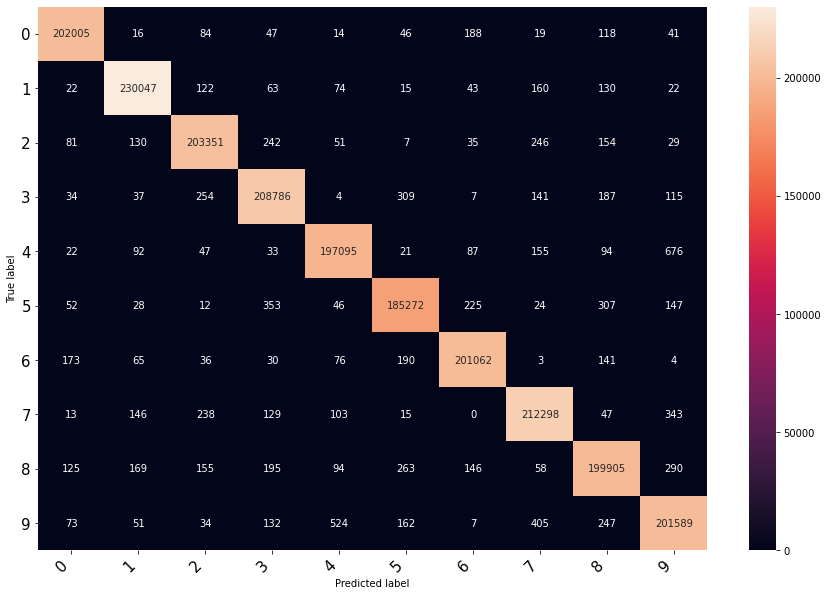

Epoch=  39 , batch =  0 , cost =  0.0012839616974815726 , accuracy =  1.0
Epoch=  39 , batch =  625 , cost =  6.911704986123368e-05 , accuracy =  1.0
Epoch=  39 , batch =  1250 , cost =  2.8478756576078013e-05 , accuracy =  1.0
Validate Epoch=  39 , batch =  0 , cost =  0.0038424294907599688 , accuracy =  1.0
Epoch:  39  averaged cost =  0.000771070655900985  train accuracy =  0.9949687272147284


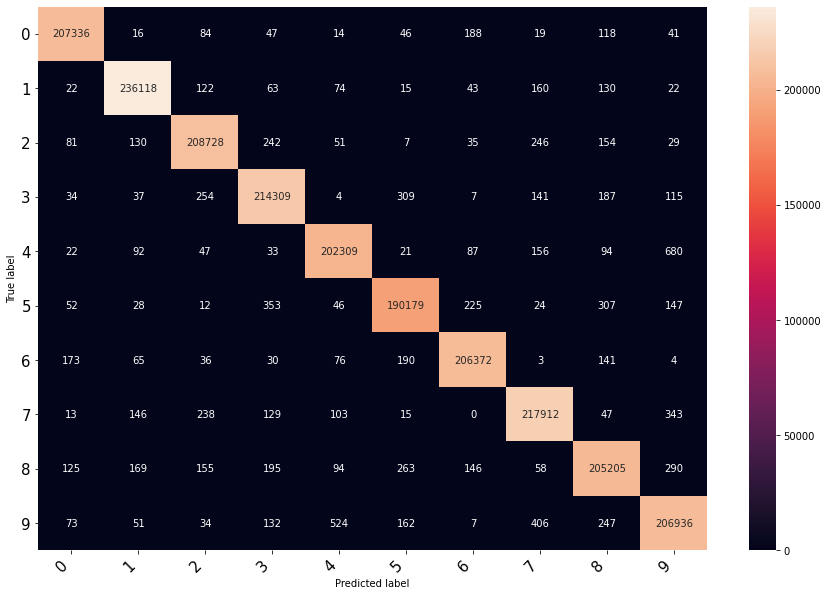

Epoch=  40 , batch =  0 , cost =  6.966228625060467e-07 , accuracy =  1.0
Epoch=  40 , batch =  625 , cost =  1.2591312952281442e-06 , accuracy =  1.0
Epoch=  40 , batch =  1250 , cost =  4.63408105133567e-06 , accuracy =  1.0
Validate Epoch=  40 , batch =  0 , cost =  1.8998823634319706e-06 , accuracy =  1.0
Epoch:  40  averaged cost =  0.0007692094659432769  train accuracy =  0.9950917320793838


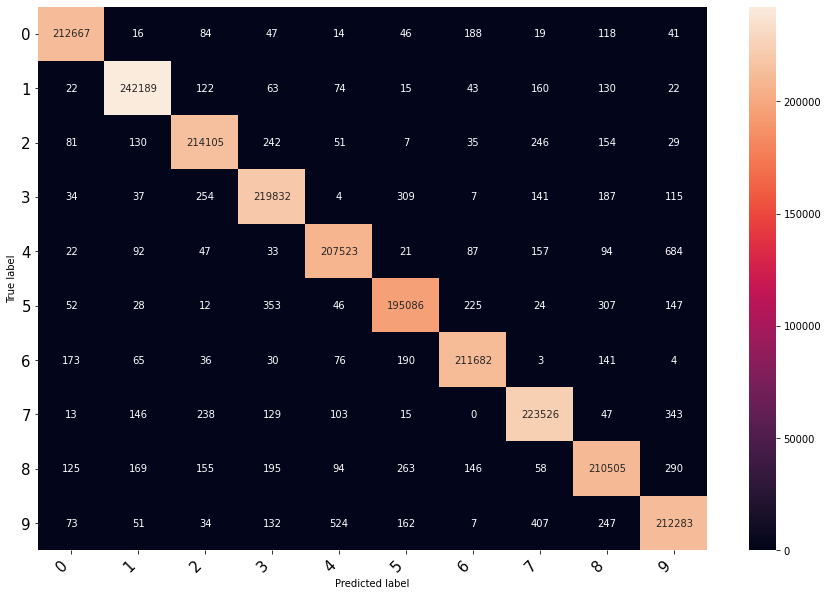

Epoch=  41 , batch =  0 , cost =  1.0430802888095059e-07 , accuracy =  1.0
Epoch=  41 , batch =  625 , cost =  2.9429685355353286e-07 , accuracy =  1.0
Epoch=  41 , batch =  1250 , cost =  1.490112708779634e-07 , accuracy =  1.0
Validate Epoch=  41 , batch =  0 , cost =  0.00012109636736568063 , accuracy =  0.96875
Epoch:  41  averaged cost =  0.0007679857662878931  train accuracy =  0.9952087367067391


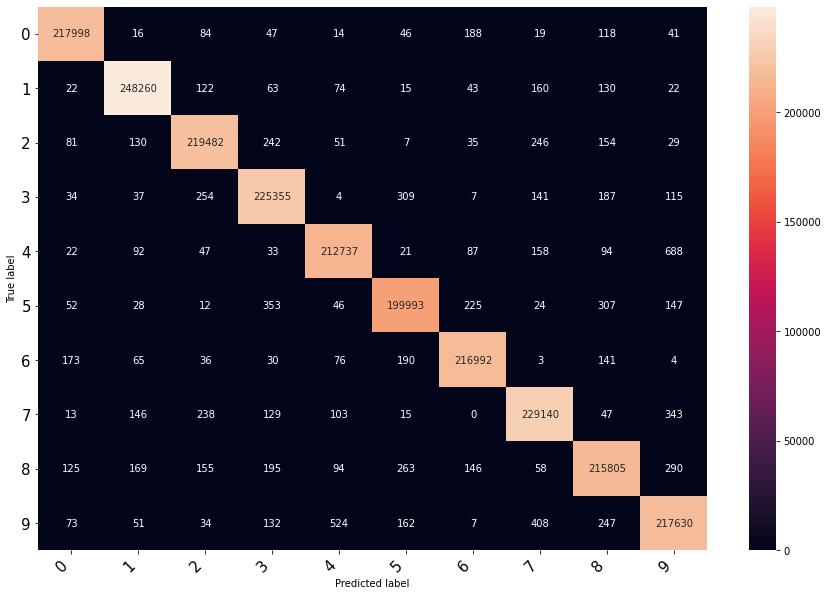

Epoch=  42 , batch =  0 , cost =  0.0011714617721736431 , accuracy =  1.0
Epoch=  42 , batch =  625 , cost =  2.3469266352549312e-07 , accuracy =  1.0
Epoch=  42 , batch =  1250 , cost =  1.5273660380898946e-07 , accuracy =  1.0
Validate Epoch=  42 , batch =  0 , cost =  7.450580152834618e-09 , accuracy =  1.0
Epoch:  42  averaged cost =  0.0007679000846110284  train accuracy =  0.9953201696851727


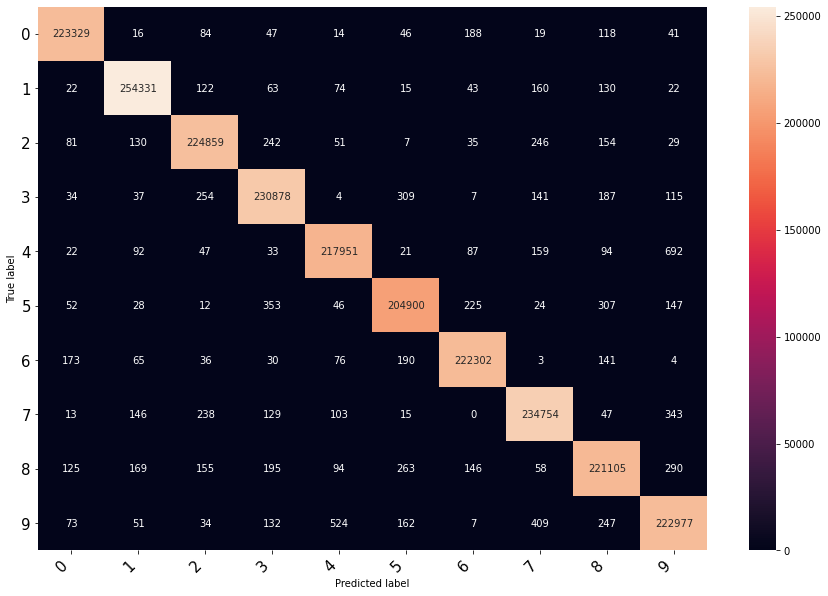

Epoch=  43 , batch =  0 , cost =  0.0024736851919442415 , accuracy =  1.0
Epoch=  43 , batch =  625 , cost =  3.725290076417309e-09 , accuracy =  1.0
Epoch=  43 , batch =  1250 , cost =  5.58793225025056e-08 , accuracy =  1.0
Validate Epoch=  43 , batch =  0 , cost =  3.87428997328243e-07 , accuracy =  1.0
Epoch:  43  averaged cost =  0.0007678380352444947  train accuracy =  0.9954264197343767


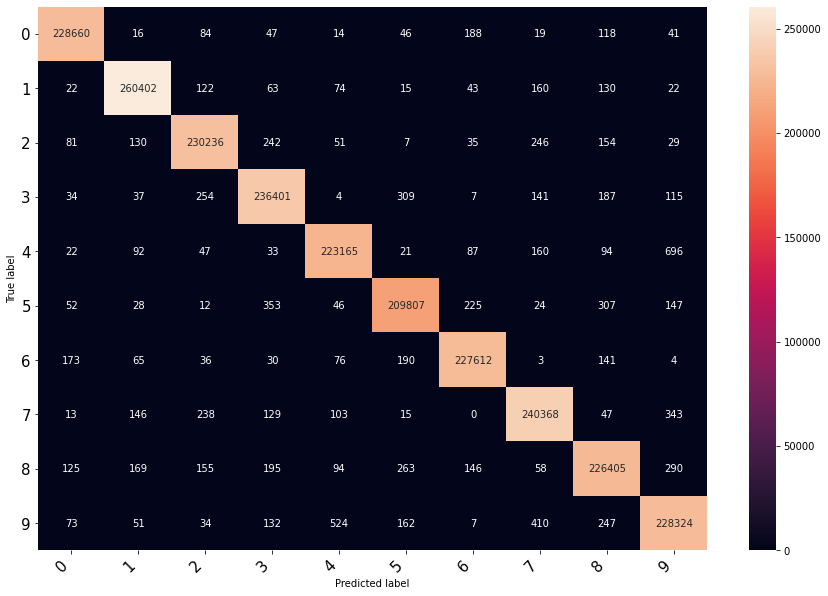

Epoch=  44 , batch =  0 , cost =  7.594955241074786e-05 , accuracy =  1.0
Epoch=  44 , batch =  625 , cost =  1.847690214162867e-06 , accuracy =  1.0
Epoch=  44 , batch =  1250 , cost =  0.002315943595021963 , accuracy =  1.0
Validate Epoch=  44 , batch =  0 , cost =  0.0005811544833704829 , accuracy =  1.0
Epoch:  44  averaged cost =  0.0007679531699977815  train accuracy =  0.9955278402358897


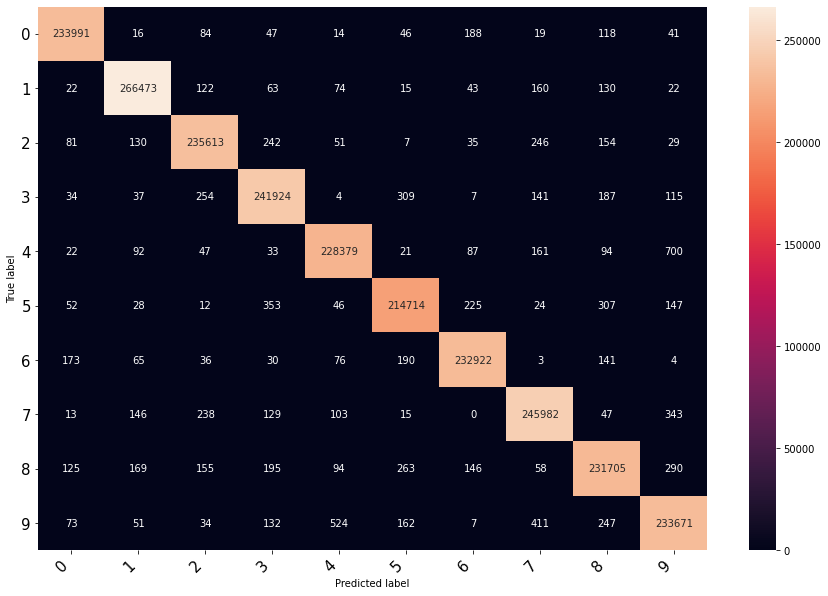

Epoch=  45 , batch =  0 , cost =  8.841750241117552e-05 , accuracy =  1.0
Epoch=  45 , batch =  625 , cost =  2.6405175958643667e-05 , accuracy =  1.0
Epoch=  45 , batch =  1250 , cost =  3.464501219241356e-07 , accuracy =  1.0
Validate Epoch=  45 , batch =  0 , cost =  4.544959665508941e-05 , accuracy =  0.96875
Epoch:  45  averaged cost =  0.0007677306421101093  train accuracy =  0.9956247531595577


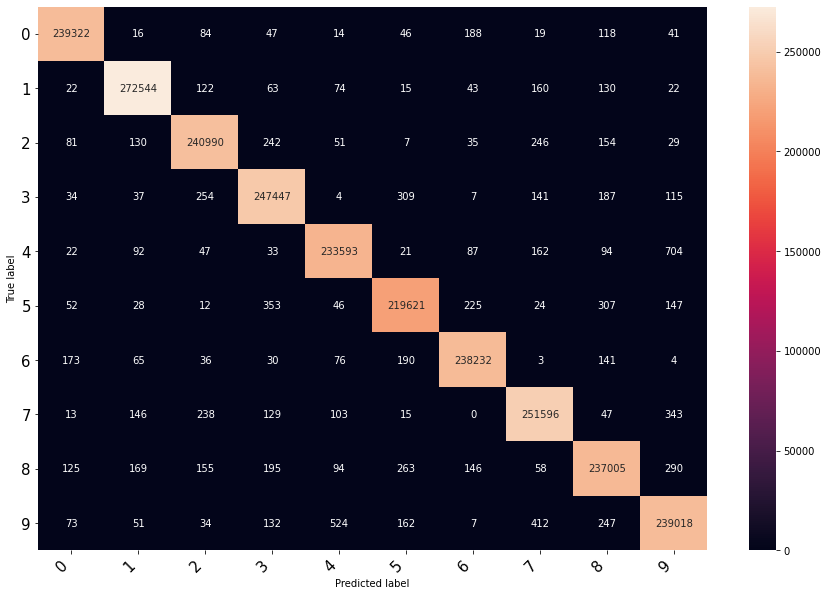

Epoch=  46 , batch =  0 , cost =  3.6456771340454e-05 , accuracy =  1.0
Epoch=  46 , batch =  625 , cost =  8.413792966166511e-05 , accuracy =  1.0
Epoch=  46 , batch =  1250 , cost =  5.625157655231305e-07 , accuracy =  1.0
Validate Epoch=  46 , batch =  0 , cost =  1.0430806440808738e-07 , accuracy =  1.0
Epoch:  46  averaged cost =  0.0007676675450056791  train accuracy =  0.9957174524778487


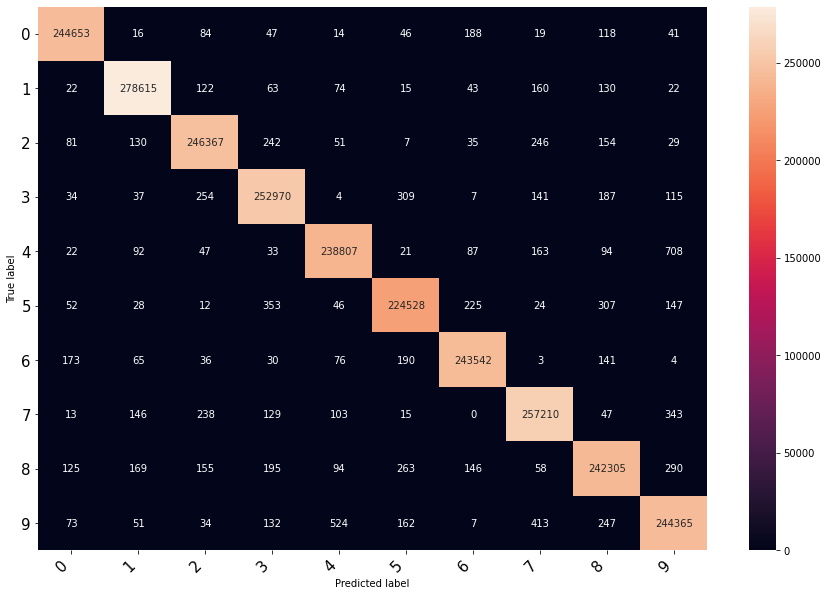

Epoch=  47 , batch =  0 , cost =  0.00027636787854135036 , accuracy =  1.0
Epoch=  47 , batch =  625 , cost =  8.717122454982018e-07 , accuracy =  1.0
Epoch=  47 , batch =  1250 , cost =  0.0009574471623636782 , accuracy =  1.0
Validate Epoch=  47 , batch =  0 , cost =  1.1920920428565296e-07 , accuracy =  1.0
Epoch:  47  averaged cost =  0.0007676063105463982  train accuracy =  0.9958062071442977


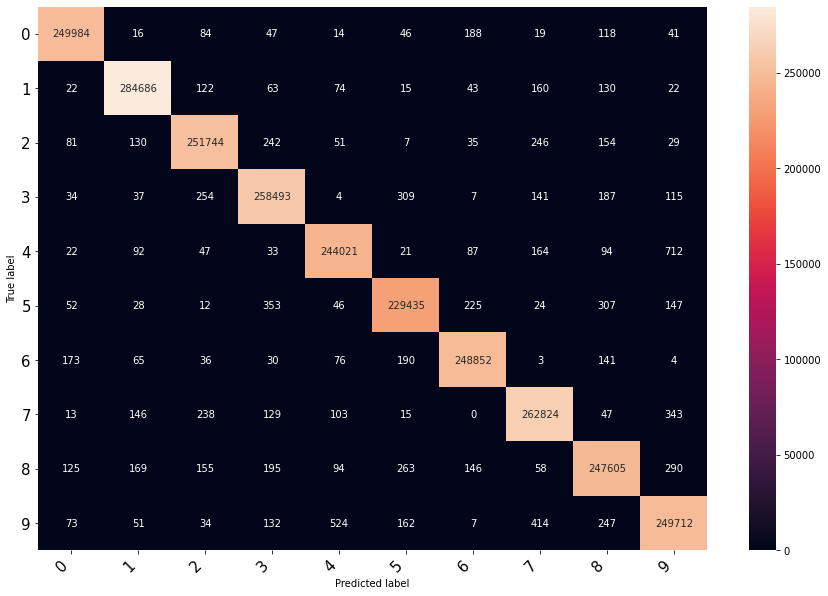

Epoch=  48 , batch =  0 , cost =  0.00030776485800743103 , accuracy =  1.0
Epoch=  48 , batch =  625 , cost =  0.00755876861512661 , accuracy =  1.0
Epoch=  48 , batch =  1250 , cost =  6.412989023374394e-05 , accuracy =  1.0
Validate Epoch=  48 , batch =  0 , cost =  2.689602752070641e-06 , accuracy =  1.0
Epoch:  48  averaged cost =  0.0007675508968532085  train accuracy =  0.9958912636996445


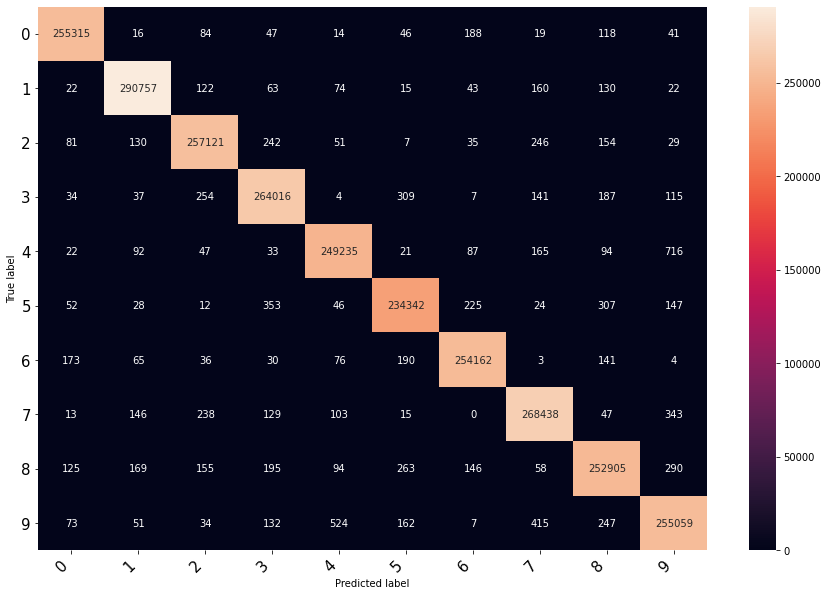

Epoch=  49 , batch =  0 , cost =  6.332990665214311e-08 , accuracy =  1.0
Epoch=  49 , batch =  625 , cost =  0.00017287739319726825 , accuracy =  1.0
Epoch=  49 , batch =  1250 , cost =  0.0010019788751378655 , accuracy =  1.0
Validate Epoch=  49 , batch =  0 , cost =  0.0038198810070753098 , accuracy =  0.96875
Epoch:  49  averaged cost =  0.0007686238968744874  train accuracy =  0.9959728485588548


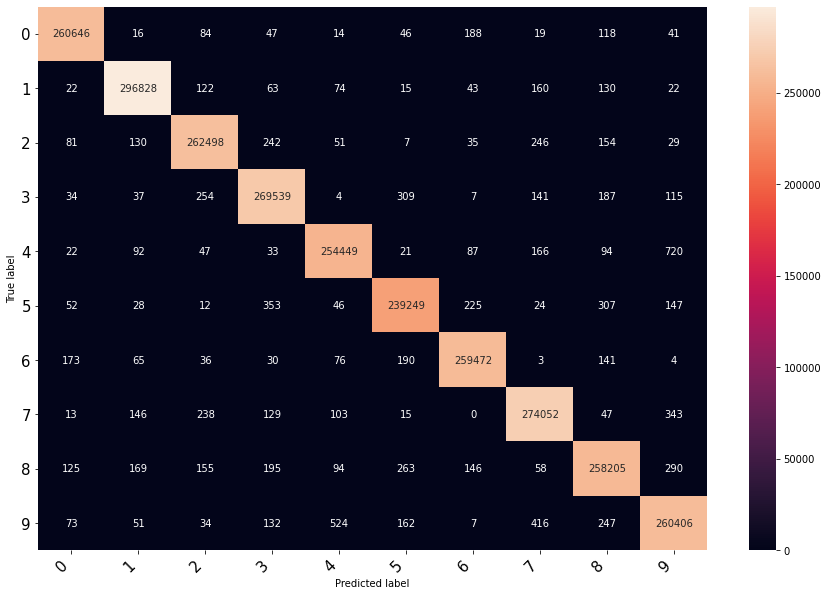

Epoch=  50 , batch =  0 , cost =  2.4615035727038048e-05 , accuracy =  1.0
Epoch=  50 , batch =  625 , cost =  0.0023024906404316425 , accuracy =  1.0
Epoch=  50 , batch =  1250 , cost =  2.516946551622823e-05 , accuracy =  1.0
Validate Epoch=  50 , batch =  0 , cost =  3.532067057676613e-05 , accuracy =  1.0
Epoch:  50  averaged cost =  0.0007674452499486506  train accuracy =  0.9960511700236967


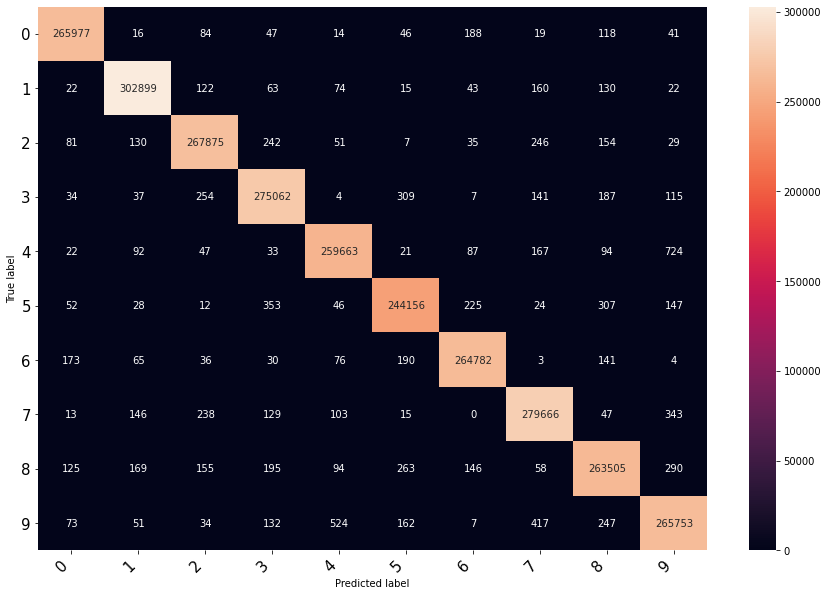

Learning Finished!
 averaged cost =  0.013618227881379426  train accuracy =  98.82987839159861


In [13]:
print('Training the Deep Learning network ...')
train_cost = []
train_accuracy = []
#accuracy_total_train= []
total_avg_cost=[]
total_avg_accuracy=[]
validate_cost=[]
validate_accuracy=[]
total_validate_cost=[]
total_validate_accuracy=[]
avgv=0
training_epochs = 50
total_batch = len(train) // batch_size
print("total_batch ", total_batch)

#print('Size of the training dataset is ',train.data.size())
print('Size of the testing dataset ',test.data.size())
print('Batch size is : ',batch_size)
print('Total number of batches is : ',total_batch)
print('Total number of epochs is :',training_epochs)
confusion_matrix = torch.zeros(10,10)
for epoch in range(training_epochs):
    avg = 0
    
    for i, (batch_X, batch_Y) in enumerate(train_loader):
        X = Variable(batch_X)    
        Y = Variable(batch_Y)    

        optimizer.zero_grad() 
        
        hypothesis = model(X)
        _, preds = torch.max(hypothesis, 1)
        for t, p in zip(Y.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
        #predlist=torch.cat([predlist,preds.view(-1).cpu()])
        #lbllist=torch.cat([lbllist,Y.view(-1).cpu()])
        cost = criterion(hypothesis, Y) 
        
        
        cost.backward()   
        optimizer.step() 
             
        
        prediction = hypothesis.data.max(dim=1)[1]
        #print(prediction)
        train_accuracy.append(((prediction.data == Y.data).float().mean()).item())
        train_cost.append(cost.item())   
        if i % 625 == 0:
            #print(prediction)
            print("Epoch= ",epoch+1,", batch = ",i,", cost = ",train_cost[-1],", accuracy = ",train_accuracy[-1])
       
        avg += cost.data / total_batch
    model.eval()    
    for i, (batch_X, batch_Y) in enumerate(validation_loader):
        X = Variable(batch_X)    
        Y = Variable(batch_Y)
        prediction=model(X)
        #costv = criterion(hypothesis, Y)     
        #costv.backward()
        validate_cost.append(cost.item())
        validate_prediction = (torch.max(prediction.data, dim=1)[1] == Y.data)
        validate_accuracy.append(validate_prediction.float().mean().item()) 
        if i % 625 == 0:
                #print(prediction)
                print("Validate Epoch= ",epoch+1,", batch = ",i,", cost = ",validate_cost[-1],", accuracy = ",validate_accuracy[-1])
        #acc.append(accuracy)
        avgv+=cost.data/total_batch
    
    scheduler.step()
    print("Epoch: ",epoch+1," averaged cost = ",avg.tolist()," train accuracy = ",sum(train_accuracy)/len(train_accuracy))
    total_avg_cost.append(avg.tolist())
    total_avg_accuracy.append(sum(train_accuracy)/len(train_accuracy))
    total_validate_cost.append(avgv.tolist())
    total_validate_accuracy.append(sum(validate_accuracy)/len(validate_accuracy))
    #Displaying Confusing Matrix in form of Heatmap.
    plt.figure(figsize=(15,10))

    class_names = ["0","1","2","3","4","5","6","7","8","9"]
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
        

print('Learning Finished!')
print(" averaged cost = ",sum(total_avg_cost)/len(total_avg_cost)," train accuracy = ",(sum(total_avg_accuracy)/len(total_avg_accuracy))*100)

In [14]:
print(" averaged cost = ",sum(total_validate_cost)/len(total_validate_cost)," train accuracy = ",(sum(total_validate_accuracy)/len(total_validate_accuracy))*100)
print(total_validate_cost)
print(total_avg_cost)

 averaged cost =  0.07818786476782406  train accuracy =  98.42927123066539
[0.00011136012471979484, 0.0020146623719483614, 0.002151931868866086, 0.036350175738334656, 0.03656098246574402, 0.07919814437627792, 0.07920654863119125, 0.0812319740653038, 0.08162137120962143, 0.08163817971944809, 0.08200236409902573, 0.08200236409902573, 0.08223908394575119, 0.08224048465490341, 0.08481358736753464, 0.08481358736753464, 0.08481358736753464, 0.08481358736753464, 0.08487241715192795, 0.08487241715192795, 0.08487241715192795, 0.08487241715192795, 0.0849018320441246, 0.0849018320441246, 0.08612605184316635, 0.08612605184316635, 0.08613725751638412, 0.08613725751638412, 0.08613725751638412, 0.08613725751638412, 0.08613725751638412, 0.08613725751638412, 0.08613725751638412, 0.08613725751638412, 0.08630954474210739, 0.08631094545125961, 0.08654346317052841, 0.0865490660071373, 0.08697768300771713, 0.08697768300771713, 0.08699169009923935, 0.08699169009923935, 0.08699169009923935, 0.0870561227202415

Accuracy Curves


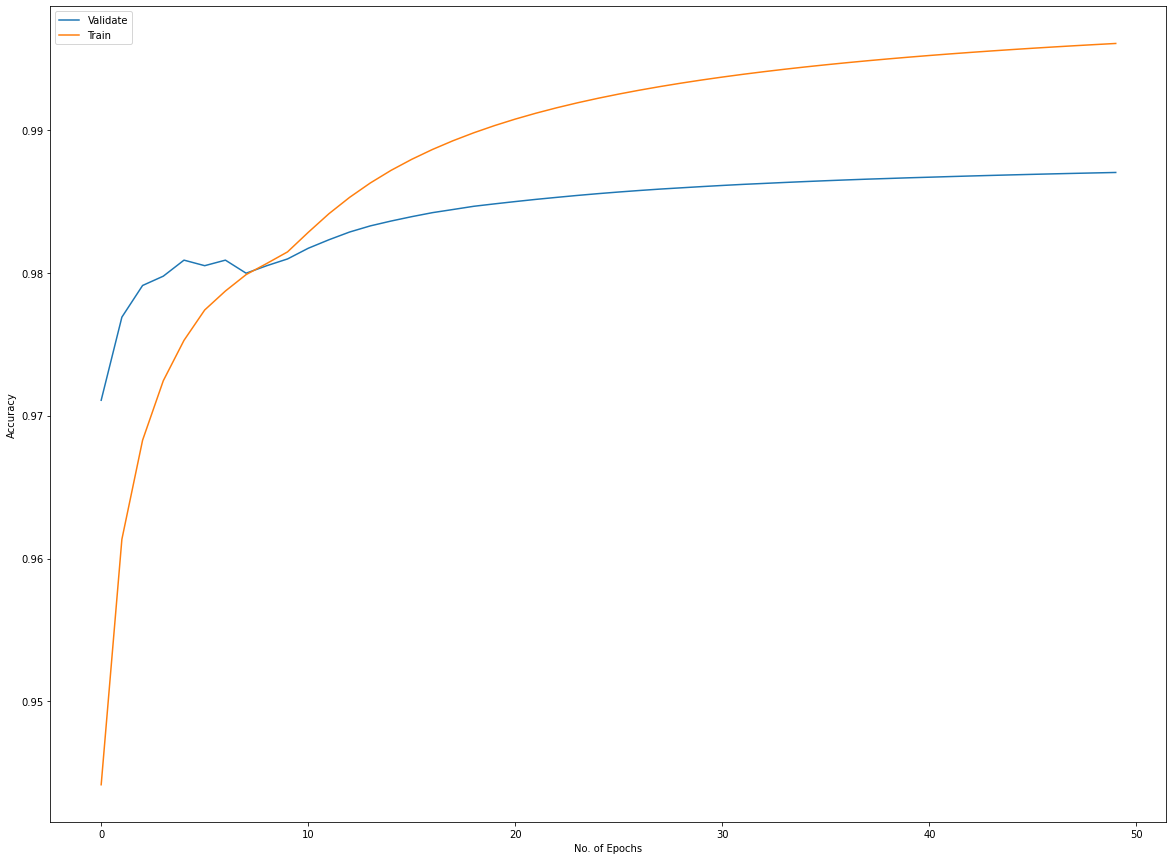

In [15]:
#Displaying Accuracy Curves
print("Accuracy Curves")
plt.figure(figsize=(20,15))
plt.plot(total_validate_accuracy,label="Validate")
plt.plot(total_avg_accuracy,label="Train")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
# From the above accuracy graphs you can see that as the model is being trained the accuracy is increasing. Similarly for the validation the accuray increases as the epochs increases.
#So, the graph reasonably fits.

Loss Curves


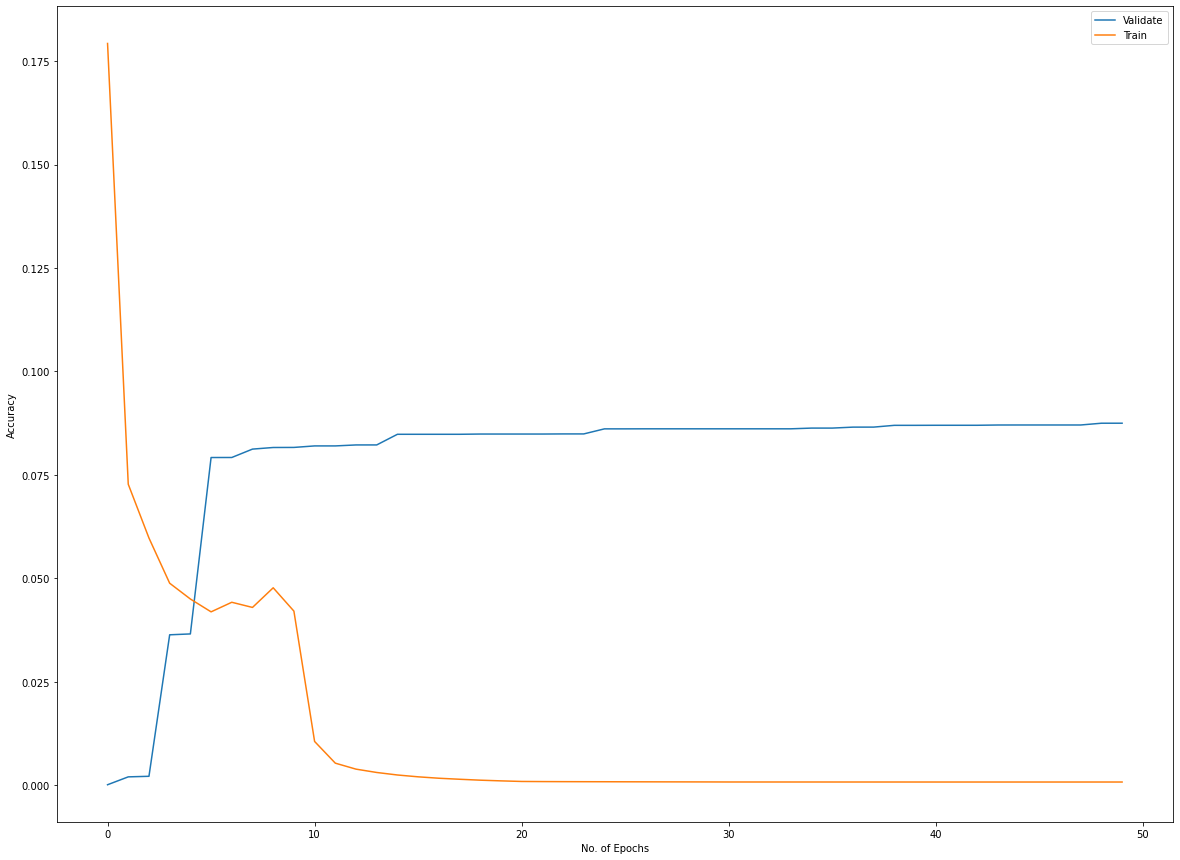

In [17]:
#Displaying Loss Curves
print("Loss Curves")
plt.figure(figsize=(20,15))
plt.plot(total_validate_cost,label="Validate")
plt.plot(total_avg_cost,label="Train")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
#From the above loss graph, we  can see that the as the model is training the cost gradually decreases. The cost for validation is slightly increasing as the epochs increasse.
# So, the graph reasonably fits.

In [4]:
'''model.eval()

X_test = Variable(test.data.view(len(test), 1, 28, 28).float())
Y_test = Variable(test.targets)

prediction = model(X_test)

# Compute accuracy
print((torch.max(prediction.data, dim=1)[1]))
#print(len((torch.max(prediction.data, dim=1)[1]).tolist()))

correct_prediction = (torch.max(prediction.data, dim=1)[1] == Y_test.data)
print("No. of Images Tested = ",len(test))
accuracy = correct_prediction.float().mean().item()
print('\nAccuracy: {:2.2f} %'.format(accuracy*100))'''

'model.eval()\n\nX_test = Variable(test.data.view(len(test), 1, 28, 28).float())\nY_test = Variable(test.targets)\n\nprediction = model(X_test)\n\n# Compute accuracy\nprint((torch.max(prediction.data, dim=1)[1]))\n#print(len((torch.max(prediction.data, dim=1)[1]).tolist()))\n\ncorrect_prediction = (torch.max(prediction.data, dim=1)[1] == Y_test.data)\nprint("No. of Images Tested = ",len(test))\naccuracy = correct_prediction.float().mean().item()\nprint(\'\nAccuracy: {:2.2f} %\'.format(accuracy*100))'

Testing the Deep Learning network ...


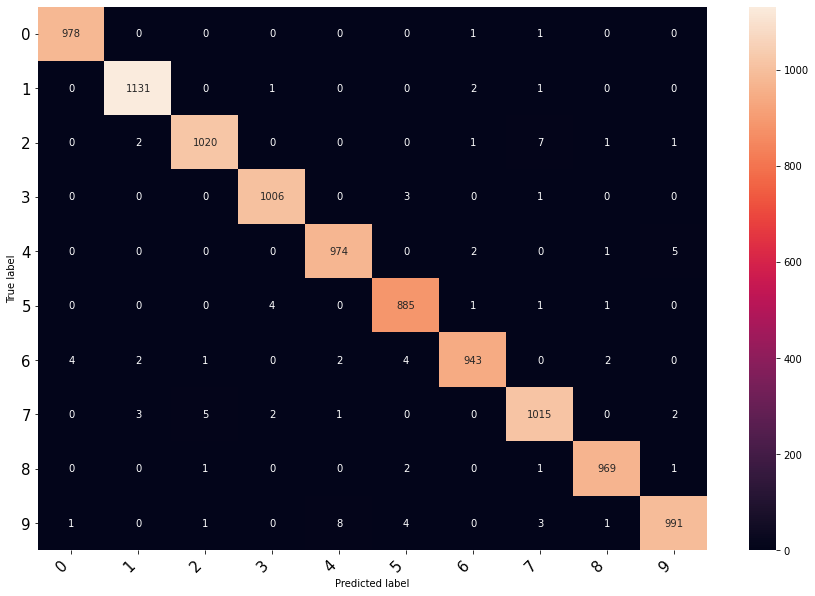

Accuracy is 99.12140575079871


In [20]:
print('Testing the Deep Learning network ...')
model.eval()
accuracy=0
acc=[]
#predlist_test=torch.zeros(0,dtype=torch.long, device='cpu')
#lbllist_test=torch.zeros(0,dtype=torch.long, device='cpu')
confusion_matrix1 = torch.zeros(10,10)
for i,(batch_X,batch_Y) in enumerate(test_loader):
    X = Variable(batch_X)    
    Y = Variable(batch_Y)
    prediction=model(X)
    _, preds = torch.max(prediction, 1)
    for t, p in zip(Y.view(-1), preds.view(-1)):
            confusion_matrix1[t.long(), p.long()] += 1
    correct_prediction = (torch.max(prediction.data, dim=1)[1] == Y.data)
    accuracy = correct_prediction.float().mean().item()
    acc.append(accuracy)
plt.figure(figsize=(15,10))

class_names = ["0","1","2","3","4","5","6","7","8","9"]
df_cm = pd.DataFrame(confusion_matrix1, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print("Accuracy is", (sum(acc)/len(acc))*100)
    

REFERENCES:-

https://www.analyticsvidhya.com/blog/2020/07/how-to-train-an-image-classification-model-in-pytorch-and-tensorflow/

https://medium.com/@snehitha_tiger/for-a-beginner-how-to-start-with-cnn-using-mnist-dataset-6f9a05d92c50
https://towardsdatascience.com/build-a-fashion-mnist-cnn-pytorch-style-efb297e22582

https://www.kaggle.com/isbhargav/guide-to-pytorch-learning-rate-scheduling

https://discuss.pytorch.org/t/weight-initilzation/157/54

https://stackoverflow.com/questions/53290306/confusion-matrix-and-test-accuracy-for-pytorch-transfer-learning-tutorial


In this Question we have applied a CNN model on MNIST Dataset. The CNN model consists of 2 hidden layers. We have done Glorot Initialisation.
We have used Stochastic Gradient Descent Optimiser with momentum of 0.9. There is a learning rate scheduler that increases the learning rate by 10% per 10 epochs and has been initiated with the value of 0.05.
We have divided the dataset into 3 parts namely, training, validation and testing dataset.
We have drawn the graphs of accuracy and cost for training and validation dataset.
From the Accuracy Graph, we can see that the accuracy increases as the model is being trained. So, the graph regularly fits.
We have shown the confusion matrix for every epoch as well as for the testing values.

The Accuracy of the model is 99.12%